# TIME SERIES ANALYSIS - FAVOURITA STORE(S)

#  Step 1: Bussiness Understanding

### **Project Background** 



As data scientists in Corporation Favorita, a large Ecuadorian-based grocery retailer. Corporation Favorita wants to ensure that they always have the right quantity of products in stock. To do this we have decided to build a series of machine learning models to forecast the demand of products in various locations. The marketing and sales team have provided us some data to aid this endeavor.

### **Goal**

To build a Time Series model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores from Corporation Favorita. 

**Objective**
- To develop a model to predict Unit Sales for thousands of items sold at different Favorita stores.
- To Evaluate Sales Trends , Patterns and Factors influencing sales.
- To Identify External factors that affect sales like Holidays,promomtions and special events eg.Earthquakes 
- To Evaluate Store Performance across different regions and stores

**Bussiness Success Criteria**

- Mainly to achieve a forcast accuracy for unit sales products across various 

- Cost Savings : Realize a cost reduction in inventory management expenses (e.g., warehousing, holding costs) by 20% through optimized stock levels.'

- Improved Inventory Turnover Rate:

Increase the inventory turnover rate by 40% over the next year, indicating more efficient stock management based on accurate demand forecasting.


##### Hypothesis
Null Hypothesis H0 = Time series is not stationary.

Alternate Hypothesis(H1): Time series data is Stationary.


## Step 2:  Data Understanding

##### **File Descriptions and Data Field Information.**

**train.csv**

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

- **store_nbr**  identifies the store at which the products are sold.

- **family** identifies the type of product sold.

- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- **onpromotion**  gives the total number of items in a product family that were being promoted at a store at a given date.

**test.csv**

- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

- The dates in the test data are for the 15 days after the last date in the training data.

**transaction.csv**

- Contains date, store_nbr and transaction made on that specific date.
sample_submission.csv

- A sample submission file in the correct format.

**stores.csv** 

- Store metadata, including city, state, type, and cluster.

- cluster is a grouping of similar stores.

**Analytical Questions**

-  Is the train dataset complete (has all the required dates)?
-   Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
-  Compare the sales for each month across the years and determine which month of which year had the highest sales.
-  Did the earthquake impact sales?
-  Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
-  Are sales affected by promotions, oil prices and holidays?
-  What analysis can we get from the date and its extractable features?
-  Which product family and stores did the promotions affect.
-  What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
-  Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

### Loading Datasets

In [2]:
import pyodbc
from dotenv import dotenv_values #import the dotenv_values function from the dotenv package
import pandas as pd
import numpy as np
import datetime as datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Machine learning
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import calendar
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import linregress
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Get the values for the credentials you set in the '.env' file
environment_variables = dotenv_values('.env')

database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [4]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
print(connection_string)

DRIVER={SQL Server};SERVER=dap-projects-database.database.windows.net;DATABASE=dapDB;UID=learning_project_3;PWD=A$uB1Lp3$2@24


In [6]:
connection = pyodbc.connect(connection_string)

In [7]:
query1= "Select * from dbo.oil"
query2= "Select * from dbo.holidays_events"
query3= "Select * from dbo.stores"

In [8]:

df_oil = pd.read_sql(query1, connection)
df_holidays_events = pd.read_sql(query2, connection)
df_stores= pd.read_sql(query3, connection)

### Exploratory Data Analysis


### Assessing the Data Quality 
- Looking into the uploaded datasets before merging

In [9]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [9]:
df_oil.tail(10)

,date,dcoilwtico
1208,2017-08-18,48.590000
1209,2017-08-21,47.389999
1210,2017-08-22,47.650002
1211,2017-08-23,48.450001
1212,2017-08-24,47.240002
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999
1217,2017-08-31,47.259998


In [10]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [11]:
df_oil.isnull().sum()
# Table1 has 43 null values 

date           0
dcoilwtico    43
dtype: int64

In [12]:
df_oil.duplicated().sum()
# There are no duplicates

np.int64(0)

In [13]:
# Filter to view only the rows with null values in the 'dcoilwtico' column
null_values_table1 = df_oil[df_oil['dcoilwtico'].isnull()]
null_values_table1


,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


*Insights on Oil Data* 

- The 'date' column in the oil data represents the date when the oil price was recorded. It ranges from January 1, 1985, to December 31, 2019.
- The 'dcoilwtico' column in the oil data represents the price of a barrel stream.

- The 'dcoilwtico' column contains daily oil prices from 2013-2017. It has 43 null values. These null values are likely due to missing data or holidays

- The oil data has no duplicates 

In [10]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [15]:
df_holidays_events.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [16]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [17]:
df_holidays_events.isnull().sum()
# No Null values here

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

- Insights from the ***Holiday_Events*** data

- The 'date' column in the holiday_events data represents the date when the holiday occurred. It ranges from January 1, 2012, to December 31, 2017.
- The Holiday_Events data contains no null values and locale_name is the name of the holiday event that occurred during the holiday event period
- the data contains no duplicates
- The locale can be identifies as the market scope for which the storess are spread across the world.(Regional,national and Local)
- The locale_name descrobes the provinces or cities the stores are situated
- The type depicts the type of holiday event

In [18]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [20]:
df_stores.isnull().sum()
# Table 3 has no null values

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

**Insights on df_stores**
- The dataset has no null values oe duplicates.
- the type depicts the store types
- The 'cluster' column in the stores data represents a grouping of similar stores.

In [11]:
# Test Data
df_submission = pd.read_csv(r'C:\Users\Josephine\Desktop\Career Accelerator\Time-Series-Regression-Analysis\Datasets\sample_submission.csv')
df_test= pd.read_csv(r'C:\Users\Josephine\Desktop\Career Accelerator\Time-Series-Regression-Analysis\Datasets\test.csv')

In [22]:
df_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [23]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


- The two tests Datasets would not be touched since it will be used for forecasting 

In [12]:
# Get Final set of training Datasets.
df_train= pd.read_csv(r"C:\Users\Josephine\Desktop\Career Accelerator\Time-Series-Regression-Analysis\Datasets\train.csv")
df_transactions= pd.read_csv(r"C:\Users\Josephine\Desktop\Career Accelerator\Time-Series-Regression-Analysis\Datasets\transactions.csv")

In [25]:
# Looking into the train data
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [27]:
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [28]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [29]:
df_transactions.isnull().sum()
# No missing values in data 5

date            0
store_nbr       0
transactions    0
dtype: int64

In [30]:
df_transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [31]:
df_transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [32]:
df_transactions.duplicated().sum()

np.int64(0)

**Insights into the last 2 datasets** 
- train and Transaction datasets do not contain null values or duplicates
- The timelines are between 2013-2017

#### Merging Datasets


In [13]:

merged_tables = pd.merge(df_oil, df_holidays_events, on='date')
merged_tables.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         202 non-null    object 
 1   dcoilwtico   182 non-null    float64
 2   type         202 non-null    object 
 3   locale       202 non-null    object 
 4   locale_name  202 non-null    object 
 5   description  202 non-null    object 
 6   transferred  202 non-null    bool   
dtypes: bool(1), float64(1), object(5)
memory usage: 9.8+ KB


In [13]:
merged_tables.isna().sum()

date            0
dcoilwtico     20
type            0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

In [14]:
MT=pd.merge(merged_tables, df_train, on='date')
MT

,date,dcoilwtico,type,locale,locale_name,description,transferred,id,store_nbr,family,sales,onpromotion
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0,1,AUTOMOTIVE,0.000,0
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,1,1,BABY CARE,0.000,0
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,2,1,BEAUTY,0.000,0
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,3,1,BEVERAGES,0.000,0
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,4,1,BOOKS,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
352831,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000883,9,POULTRY,438.133,0
352832,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000884,9,PREPARED FOODS,154.553,1
352833,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000885,9,PRODUCE,2419.729,148
352834,2017-08-15,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [36]:
MT.duplicated().sum()

np.int64(0)

In [37]:
MT.isna().sum()

date               0
dcoilwtico     30294
type               0
locale             0
locale_name        0
description        0
transferred        0
id                 0
store_nbr          0
family             0
sales              0
onpromotion        0
dtype: int64

In [15]:
MT2= pd.merge(MT,df_stores,on= 'store_nbr', how='inner')
MT2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352836 entries, 0 to 352835
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         352836 non-null  object 
 1   dcoilwtico   322542 non-null  float64
 2   type_x       352836 non-null  object 
 3   locale       352836 non-null  object 
 4   locale_name  352836 non-null  object 
 5   description  352836 non-null  object 
 6   transferred  352836 non-null  bool   
 7   id           352836 non-null  int64  
 8   store_nbr    352836 non-null  int64  
 9   family       352836 non-null  object 
 10  sales        352836 non-null  float64
 11  onpromotion  352836 non-null  int64  
 12  city         352836 non-null  object 
 13  state        352836 non-null  object 
 14  type_y       352836 non-null  object 
 15  cluster      352836 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 40.7+ MB


In [16]:
MT2.isnull().sum()

date               0
dcoilwtico     30294
type_x             0
locale             0
locale_name        0
description        0
transferred        0
id                 0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type_y             0
cluster            0
dtype: int64

In [16]:
MT3=pd.merge(MT2,df_transactions,on= ['date' , 'store_nbr'] ,  how='inner')
MT3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          322047 non-null  object 
 1   dcoilwtico    300003 non-null  float64
 2   type_x        322047 non-null  object 
 3   locale        322047 non-null  object 
 4   locale_name   322047 non-null  object 
 5   description   322047 non-null  object 
 6   transferred   322047 non-null  bool   
 7   id            322047 non-null  int64  
 8   store_nbr     322047 non-null  int64  
 9   family        322047 non-null  object 
 10  sales         322047 non-null  float64
 11  onpromotion   322047 non-null  int64  
 12  city          322047 non-null  object 
 13  state         322047 non-null  object 
 14  type_y        322047 non-null  object 
 15  cluster       322047 non-null  int64  
 16  transactions  322047 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(9)
memo

In [41]:
MT3.duplicated().sum()


np.int64(0)

In [42]:
MT3.isnull().sum()

date                0
dcoilwtico      22044
type_x              0
locale              0
locale_name         0
description         0
transferred         0
id                  0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type_y              0
cluster             0
transactions        0
dtype: int64

Performing an EDA for Our Newly Merged dataset

In [17]:
# Looking Into the Data

print('='*50)
print("First five rows", "\n")
print(MT3.head(5), "\n")

print("="*50)
print("Information On Dataset",'\n')
print(MT3.info(), "\n")

print("="*50)
print("Describe the Dataset" ,'\n') 
print (MT3.describe().T, "\n")	

print("="*50)
print( "Null Values t",'\n') 
print(MT3.isnull().sum(),"\n")

print("="*50)
print("shape of the Dataset",'\n')
print(MT3.shape,"\n")

First five rows 

         date  dcoilwtico   type_x  ... type_y cluster transactions
0  2013-01-01         NaN  Holiday  ...      D       1          770
1  2013-01-01         NaN  Holiday  ...      D       1          770
2  2013-01-01         NaN  Holiday  ...      D       1          770
3  2013-01-01         NaN  Holiday  ...      D       1          770
4  2013-01-01         NaN  Holiday  ...      D       1          770

[5 rows x 17 columns] 

Information On Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          322047 non-null  object 
 1   dcoilwtico    300003 non-null  float64
 2   type_x        322047 non-null  object 
 3   locale        322047 non-null  object 
 4   locale_name   322047 non-null  object 
 5   description   322047 non-null  object 
 6   transferred   322047 non-null  bool   
 7   id          

#### Feature Engineering::

In [18]:
# Converting date into datetime

MT3['date'] = pd.to_datetime(MT3['date'])
MT3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   dcoilwtico    300003 non-null  float64       
 2   type_x        322047 non-null  object        
 3   locale        322047 non-null  object        
 4   locale_name   322047 non-null  object        
 5   description   322047 non-null  object        
 6   transferred   322047 non-null  bool          
 7   id            322047 non-null  int64         
 8   store_nbr     322047 non-null  int64         
 9   family        322047 non-null  object        
 10  sales         322047 non-null  float64       
 11  onpromotion   322047 non-null  int64         
 12  city          322047 non-null  object        
 13  state         322047 non-null  object        
 14  type_y        322047 non-null  object        
 15  cluster       322

In [19]:
# Create a Copy of the original dataframe
df_copy = MT3.copy()

# Add more datetime features to the new dataframe. 
MT3['year'] = MT3['date'].dt.year
MT3['month'] = MT3['date'].dt.month
MT3['day'] = MT3['date'].dt.day

# Replace the numeric month and day with their actual names
MT3['month_name'] = MT3['date'].dt.strftime('%B')  # Full month name
MT3['day_name'] = MT3['date'].dt.strftime('%A')    # Full day name

# Check the first few rows of the new dataframe to verify the changes
MT3.head()


,date,dcoilwtico,type_x,locale,locale_name,description,transferred,id,store_nbr,family,sales,onpromotion,city,state,type_y,cluster,transactions,year,month,day,month_name,day_name
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,561,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,562,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,563,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,564,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,565,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday


In [20]:
# Lets Change some Column names.
MT3.rename(columns={'locale':'store_marketscope', 
                    'locale_name':'store_location', 
                    'type_x':'Holiday_type',
                    'type_y':'store_type',
                    'dcoilwtico':'oil_price'}, inplace=True)
MT3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               322047 non-null  datetime64[ns]
 1   oil_price          300003 non-null  float64       
 2   Holiday_type       322047 non-null  object        
 3   store_marketscope  322047 non-null  object        
 4   store_location     322047 non-null  object        
 5   description        322047 non-null  object        
 6   transferred        322047 non-null  bool          
 7   id                 322047 non-null  int64         
 8   store_nbr          322047 non-null  int64         
 9   family             322047 non-null  object        
 10  sales              322047 non-null  float64       
 11  onpromotion        322047 non-null  int64         
 12  city               322047 non-null  object        
 13  state              322047 non-null  object  

In [21]:
# Generate a Summary statistics for The numerical columns

MT3.select_dtypes(include=['float64', 'int64']).describe().T

,count,mean,std,min,25%,50%,75%,max
oil_price,300003.0,6.407791e+01,25.147682,27.959999,44.66,5.144000e+01,9.474000e+01,1.079500e+02
id,322047.0,1.682979e+06,786249.257767,561.000000,1010616.50,1.842406e+06,2.209556e+06,3.000887e+06
store_nbr,322047.0,2.699467e+01,15.595174,1.000000,13.00,2.700000e+01,4.000000e+01,5.400000e+01
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.00,1.900000e+01,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.00,0.000000e+00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.00,9.000000e+00,1.300000e+01,1.700000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1030.00,1.409000e+03,2.148000e+03,8.359000e+03


Inference on Descrptive Statistics
- The mean **oil price** is approximately $64.08, with a standard deviation of $25.15.
- The **sales** data shows a high variability, with a mean of 406.38 and a standard deviation of 1246.88. The median sales value is much lower at 19, indicating a skewed distribution.
-  **Store numbers** range from 1 to 54, with a mean of 26.99.
-  **The "onpromotion"** feature has a median of 0, indicating that many entries have no promotions. 
- **Transaction** counts range widely, with a mean of 1734.12 and a median of 1409, suggesting some stores have significantly higher activity.

In [24]:
# generate a Summary statistics for categorical columns.

MT3.select_dtypes(include=['object','bool']).describe().T

,count,unique,top,freq
Holiday_type,322047,5,Holiday,202818
store_marketscope,322047,3,National,160710
store_location,322047,24,Ecuador,160710
description,322047,80,Carnaval,16368
transferred,322047,2,False,308352
family,322047,33,AUTOMOTIVE,9759
city,322047,22,Quito,112266
state,322047,16,Pichincha,118668
store_type,322047,5,D,110121
month_name,322047,12,December,51381


**Inference for categorical columns**

1. The majority of records are labeled as "Holiday" under the "Holiday_type" category, with 202,818 occurrences.
2. Most stores operate on a national level, as indicated by the "store_marketscope" with 160,710 entries.
3. The predominant store location is Ecuador, matching the count for national market scope.
4. A significant number of records, 308,352, indicate that no data was transferred, marked as "False".
5. Quito, located in Pichincha state, is the most common city and state combination for store locations, with 112,266 and 118,668 entries, respectively.


In [49]:
# Check the unique values in each column

MT3.select_dtypes(include=['object','bool']).nunique()

Holiday_type          5
store_marketscope     3
store_location       24
description          80
transferred           2
family               33
city                 22
state                16
store_type            5
month_name           12
day_name              5
dtype: int64

In [50]:
unique_values = MT3.select_dtypes(include=['object', 'bool']).apply(pd.Series.unique)
unique_values

Holiday_type            [Holiday, Additional, Transfer, Event, Bridge]
store_marketscope                          [National, Regional, Local]
store_location       [Ecuador, Cotopaxi, Cuenca, Imbabura, Machala,...
description          [Primer dia del ano, Carnaval, Provincializaci...
transferred                                              [False, True]
family               [AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...
city                 [Salinas, Quito, Cayambe, Latacunga, Riobamba,...
state                [Santa Elena, Pichincha, Cotopaxi, Chimborazo,...
store_type                                             [D, C, B, E, A]
month_name           [January, February, April, May, June, July, Au...
day_name                [Tuesday, Monday, Friday, Wednesday, Thursday]
dtype: object

In [51]:
#Show all the unique values in the store_location table

unique_values['store_location']

array(['Ecuador', 'Cotopaxi', 'Cuenca', 'Imbabura', 'Machala',
       'Latacunga', 'El Carmen', 'Santo Domingo', 'Cayambe', 'Guayaquil',
       'Esmeraldas', 'Riobamba', 'Quevedo',
       'Santo Domingo de los Tsachilas', 'Santa Elena', 'Ambato', 'Quito',
       'Libertad', 'Puyo', 'Guaranda', 'Loja', 'Salinas', 'Manta',
       'Ibarra'], dtype=object)

In [52]:
# Check the null values in the 'dcoilwtico' column if they are holidays
null_values_table1 = MT3[MT3['oil_price'].isnull()]
null_values_table1

,date,oil_price,Holiday_type,store_marketscope,store_location,description,transferred,id,store_nbr,family,...,city,state,store_type,cluster,transactions,year,month,day,month_name,day_name
0,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,561,25,AUTOMOTIVE,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
1,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,562,25,BABY CARE,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
2,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,563,25,BEAUTY,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
3,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,564,25,BEVERAGES,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
4,2013-01-01,NaN,Holiday,National,Ecuador,Primer dia del ano,False,565,25,BOOKS,...,Salinas,Santa Elena,D,1,770,2013,1,1,January,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313132,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924257,9,POULTRY,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday
313133,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924258,9,PREPARED FOODS,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday
313134,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924259,9,PRODUCE,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday
313135,2017-07-03,NaN,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2924260,9,SCHOOL AND OFFICE SUPPLIES,...,Quito,Pichincha,B,6,2224,2017,7,3,July,Monday


Insight = There were no sales or Nan values in the oil price because of the holidays, so we would...?

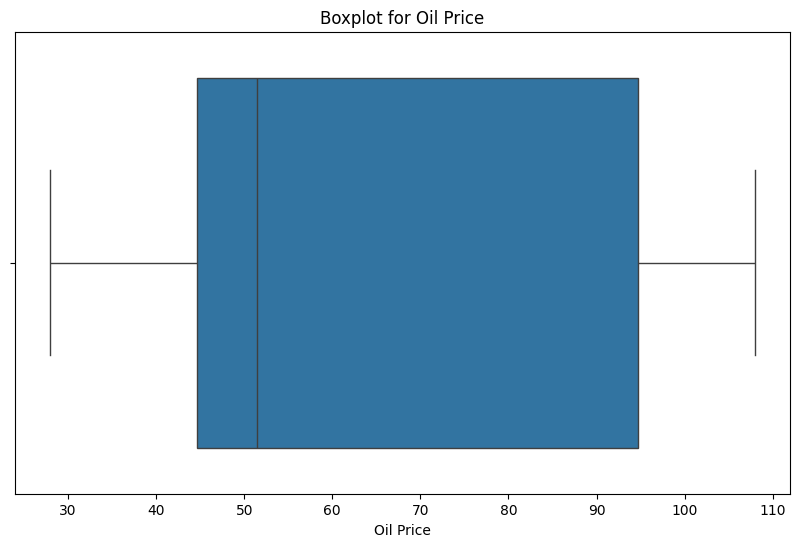

In [53]:
# Create a Boxplot for the "oil_price" column
plt.figure(figsize=(10,6))

sns.boxplot(x=MT3['oil_price'])
# Add Title and Labels

plt.title("Boxplot for Oil Price")
plt.xlabel("Oil Price")
plt.show()

**Inference=**
There are no outliers in the boxplot above
We could impute the mean using the simpleimputer or check for other methods feasible of handling the mising data here. 

### Visualizing The Data

#### Bivariate Analysis
- Trend of Oil Prices Over Time.
- We would view the trend of sales over the years(Sales Vrs Years).

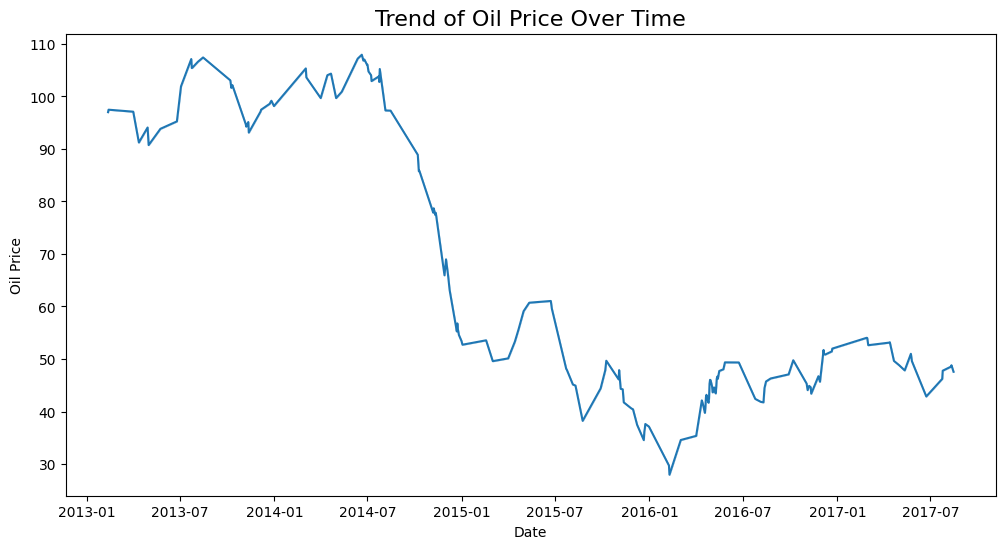

In [54]:
# Lets plot the trend of oil Prices over time using a lineplot

plt.figure(figsize=(12,6))

sns.lineplot(x='date', y='oil_price', data=MT3)
plt.title("Trend of Oil Price Over Time", fontsize=(16) )
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.show()

**Inference**

The graph shows the trend of oil prices from January 2013 to July 2017.

1. **Initial Stability and Increase**: From early 2013 to mid-2014, oil prices were relatively stable, fluctuating around $90 to $110.

2. **Significant Decline**: Starting from mid-2014, there is a sharp decline in oil prices. By early 2016, prices dropped to around $30 to $40, marking a significant decrease.

3. **Gradual Recovery**: After early 2016, there is a gradual recovery with fluctuations. Prices start to increase slowly, reaching around $50 by mid-2017.

4. **Volatility**: Throughout the period, especially during the recovery phase, there are noticeable fluctuations, indicating a volatile oil market.

The significant drop in oil prices around mid-2014 to early 2016 could be attributed to various global economic factors, including changes in supply and demand, geopolitical events, and market speculation. The gradual recovery suggests stabilization efforts and adjustments in the market dynamics. 

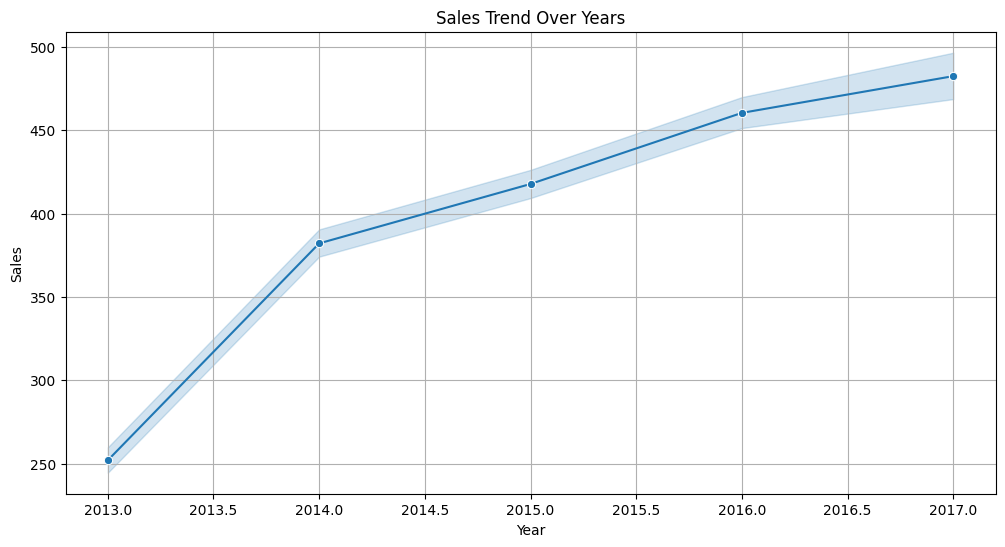

In [55]:
# Analysis of Sales over Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sales', data=MT3, marker='o')
plt.title('Sales Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

**Insights**

- Upward Trend: There is a clear upward trend in sales from 2013 to 2017. Sales increased consistently every year.

- Growth Rate:
2013 to 2014: The most significant growth occurred between 2013 and 2014, where sales jumped from around 250 to approximately 400.
2014 to 2017: From 2014 to 2017, sales continued to increase but at a more gradual and steady rate.

- Consistency: The shaded area around the line indicates the confidence interval, showing the variability of sales data. The confidence interval is relatively narrow, suggesting that the sales data is consistent and the trend is reliable.

- The consistent increase in sales suggests strong business performance and possibly effective strategies in place.
- Future Expectations: If the trend continues, it is reasonable to expect further sales growth in subsequent years.

**In summary, the trend indicates a positive and consistent increase in sales from 2013 to 2017, with the most substantial growth occurring in the early years of this period.**



Univariate Analysis

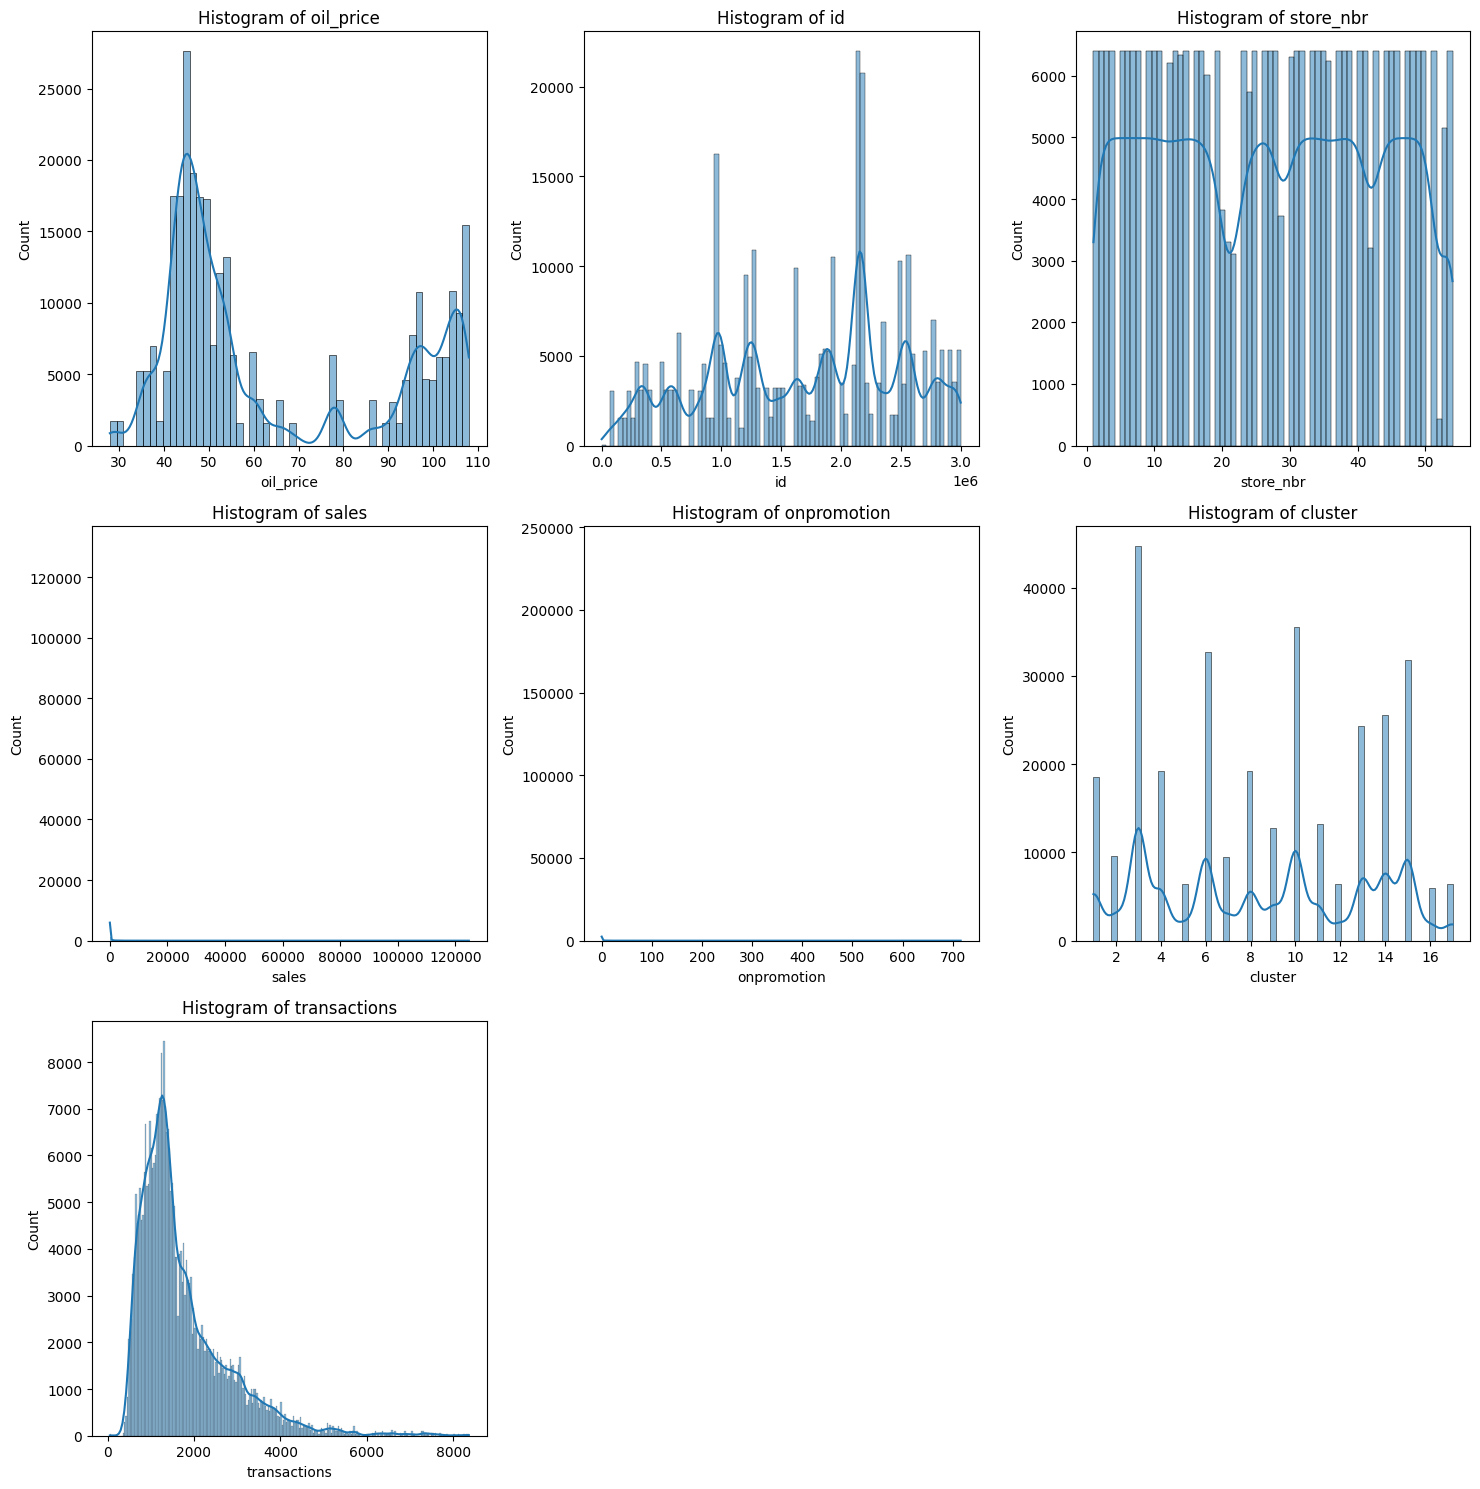

In [56]:
# Perform a univariate analysis on the data

# Create a histogram of the  numeric values each.

numeric_columns = MT3.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows needed for the subplots
n_cols = 3
n_rows = -(-len(numeric_columns) // n_cols)  # Ceiling division

# Create subplots
plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(MT3[column], kde=True)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()


#### Multivariate Analysis

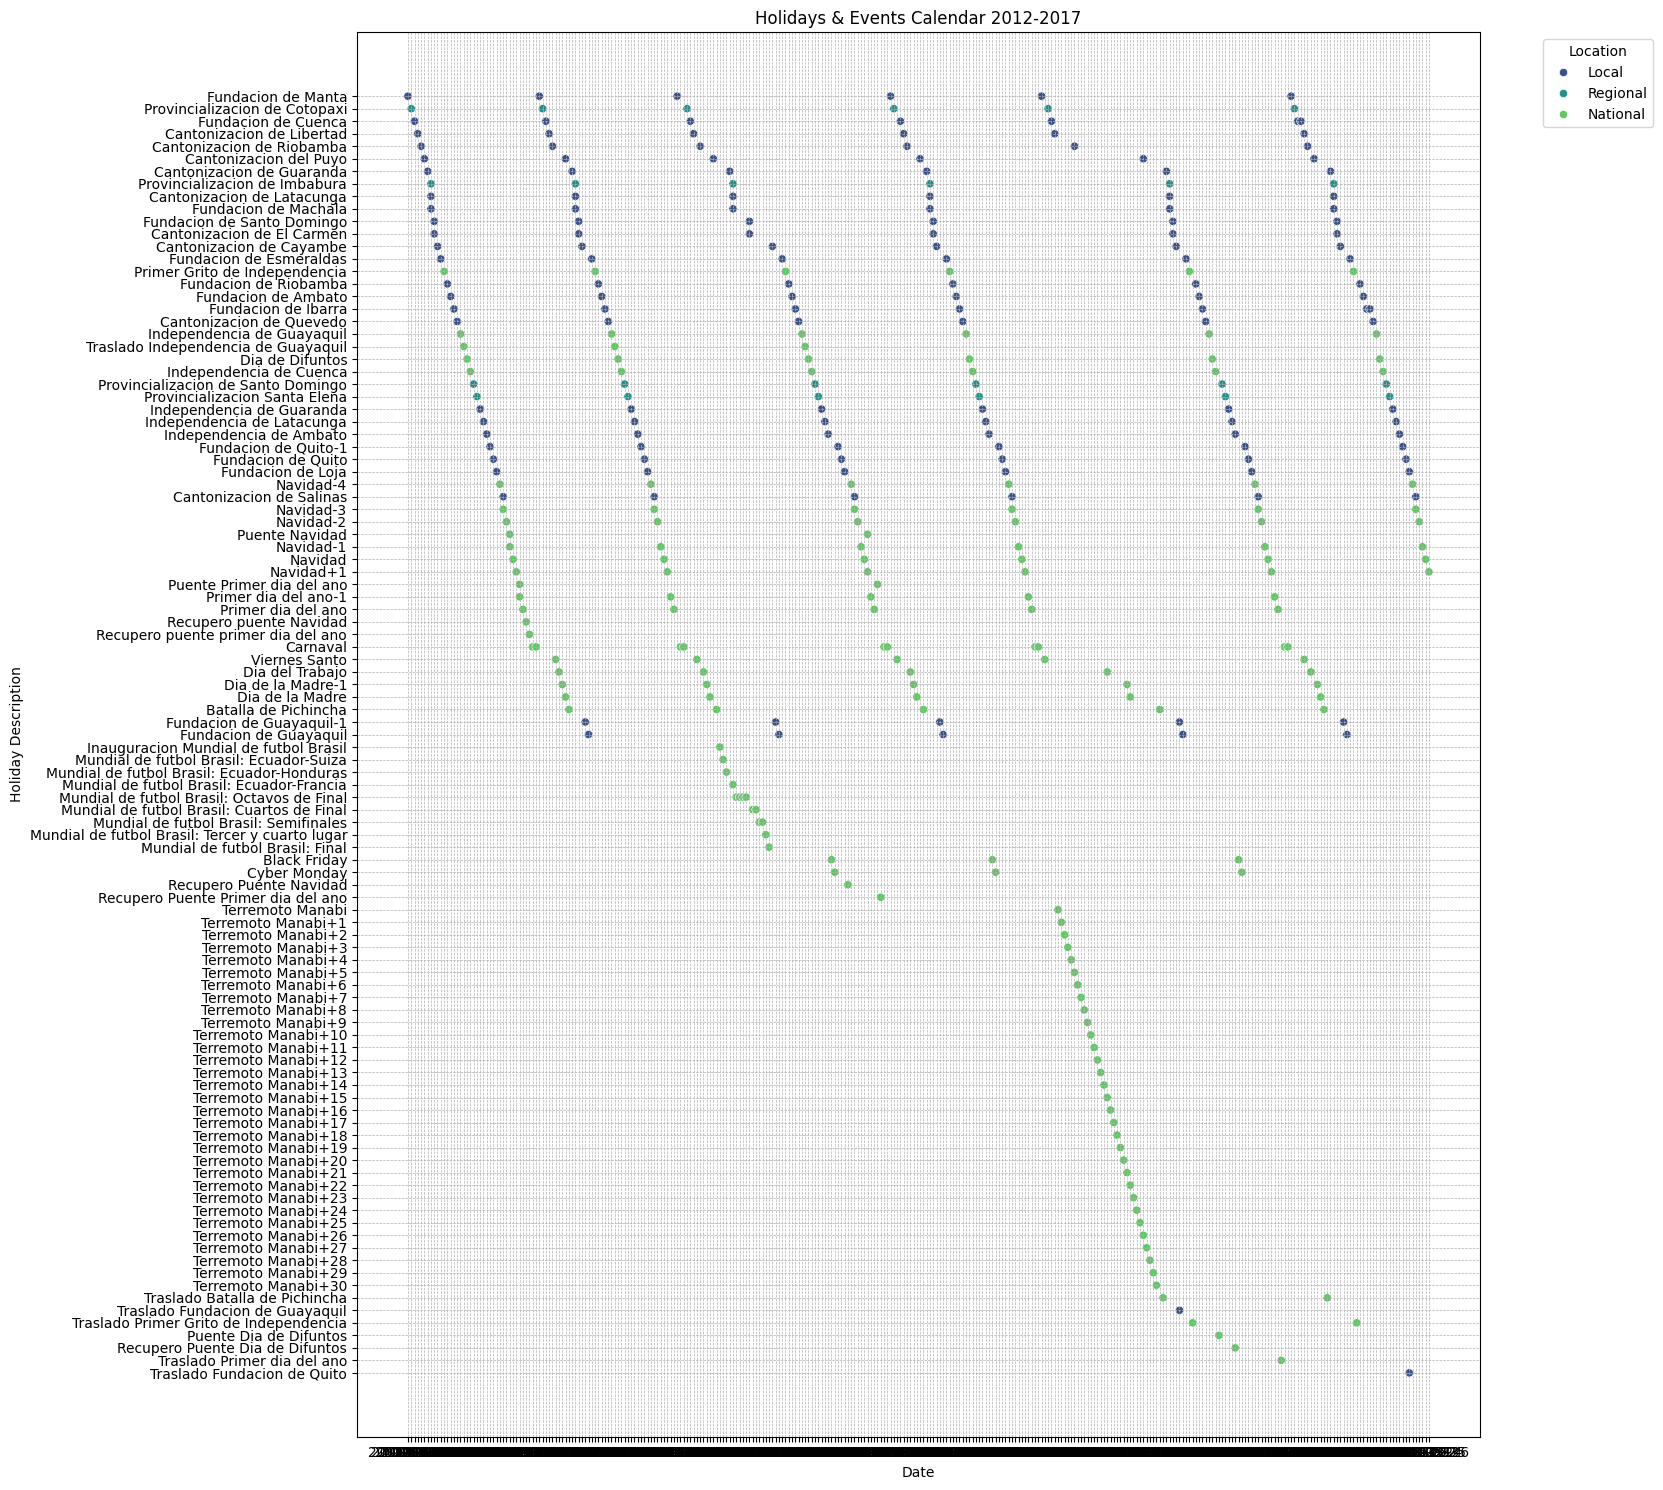

In [57]:
# Plot plt.style. the use( holidays_df 'default") dataframe into Holidays & Events calender

plt.figure(figsize=(15, 15))
sns.scatterplot(data=df_holidays_events, x='date', y='description', hue='locale', palette='viridis', marker="o")
plt.title('Holidays & Events Calendar 2012-2017')
plt.xlabel('Date')
plt.ylabel('Holiday Description')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc= 'upper left')
plt.show()
 

- Inference

From the graph,holidays are categorized into three types, distinguished by dot color: local (violet), regional (dark green), and national (light green). 
These types are interspersed throughout the years.

- Certain holidays and events appear annually, evident from vertical clusters of dots spanning each year. These likely
correspond to fixed-date holidays in Ecuador such as New Year's Day, Independence Day, or Christmas.

- Some events occur only once, representing unique national-level holidays or events. For instance, the clusters of dots in
2014 marked "Mundial de futbol Brasil" celebrate and support the Ecuador national team's participation in the 2014 FIFA
World Cup (Source).
- Similarly, the "Terremoto Manabi" event series from 2016-04-16 to 2016-05- 16 commemorates the
impact of the 2016 Ecuador earthquake. The earthquake's effect on sales will be discussed later.
 

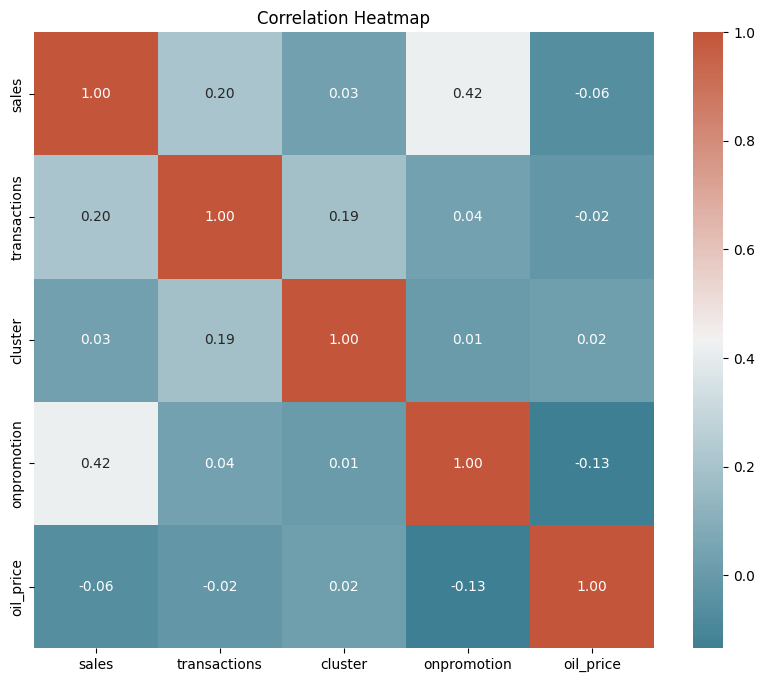

In [25]:
# Correlation numerical values
# Define the columns to include in the correlation analysis
multivariate_columns = ['sales', 'transactions', 'cluster', 'onpromotion',"oil_price"]
# Calculate the correlation matrix
corr = MT3[multivariate_columns].corr()

# Custom colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # 220 for brown, 20 for yellow

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data=corr, annot=True, cmap=cmap, fmt=".2f")

plt.title('Correlation Heatmap')
plt.show()

- Inference

1. **Sales and On Promotion**: There is a moderate positive correlation (0.42) between sales and onpromotion, indicating that promotions are likely boosting sales.
2. **Sales and Transactions**: A positive correlation (0.20) exists between sales and transactions, suggesting that more transactions generally lead to higher sales.
3. **Sales and Oil Price**: A slight negative correlation (-0.06) between sales and oil price suggests that higher oil prices might slightly impact sales negatively.
4. **Transactions and Cluster**: There is a weak positive correlation (0.19) between transactions and cluster, implying minor variability in transactions across different clusters.
5. **On Promotion and Oil Price**: A weak negative correlation (-0.13) between onpromotion and oil price indicates that higher oil prices slightly reduce the effect of promotions.

count    322047.000000
mean        406.383452
std        1246.881240
min           0.000000
25%           1.000000
50%          19.000000
75%         241.260505
max      124717.000000
Name: sales, dtype: float64


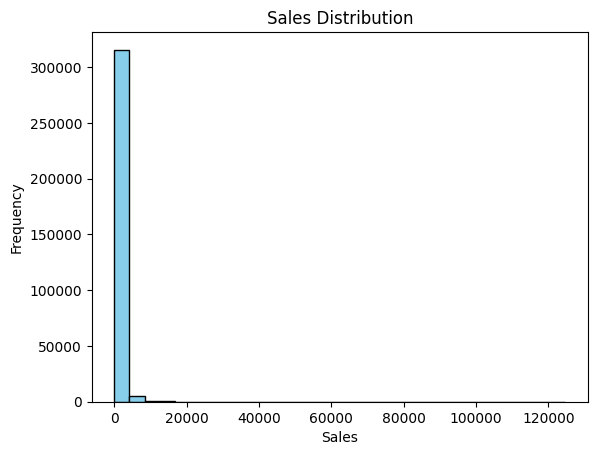

In [60]:
sales_desc = MT3['sales'].describe()
print(sales_desc)

# Histogram
plt.hist(MT3['sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()


In [61]:
# Calculate frequency and percentage
store_type_counts = MT3['store_type'].value_counts()
store_type_percent = store_type_counts / store_type_counts.sum() * 100

# Create a DataFrame for plotting
store_type_df = pd.DataFrame({'Count': store_type_counts, 'Percentage': store_type_percent})
store_type_df

,Count,Percentage
store_type,,
D,110121,34.194077
C,92367,28.681217
A,51645,16.036479
B,45144,14.017830
E,22770,7.070397


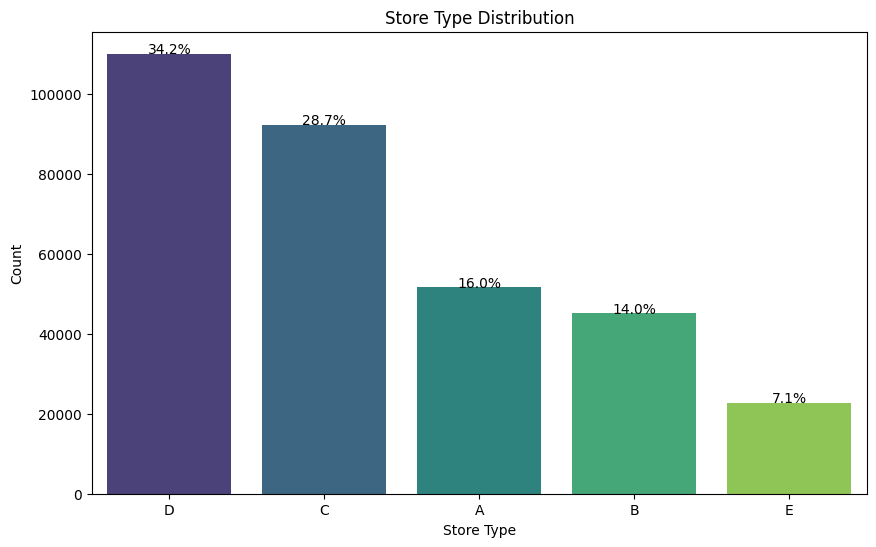

In [62]:
# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=store_type_df.index, y=store_type_df['Count'], palette='viridis')

# Annotate with percentages
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            '{:1.1f}%'.format(height / store_type_counts.sum() * 100),
            ha="center")

plt.title('Store Type Distribution')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()


**Inference** 
The bar plot displays the distribution of different store types in Ecuador, along with their respective percentages:

1. **Store Type D**: This is the most common store type, accounting for 34.2% of the total stores, with over 100,000 occurrences.
2. **Store Type C**: The second most common store type, making up 28.7% of the total, with around 90,000 occurrences.
3. **Store Type A**: This store type represents 16.0% of the total, with approximately 50,000 occurrences.
4. **Store Type B**: Slightly less common, store type B constitutes 14.0% of the stores, with about 45,000 occurrences.
5. **Store Type E**: The least common store type, comprising 7.1% of the total, with around 20,000 occurrences.

Overall, the majority of stores in Ecuador fall into types D and C, making up over 60% of the total stores.

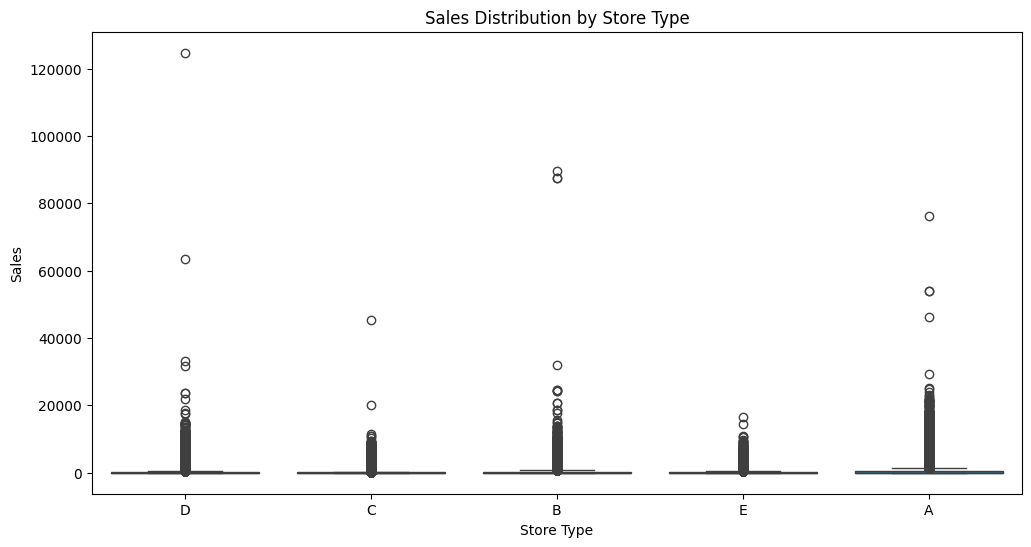

In [63]:
# Checking for the distribution of Sales in each store type
# Plotting the relationship between store type and sales
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_type', y='sales', data=MT3)
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

**NB =**
there are several outliers of sales in each store type

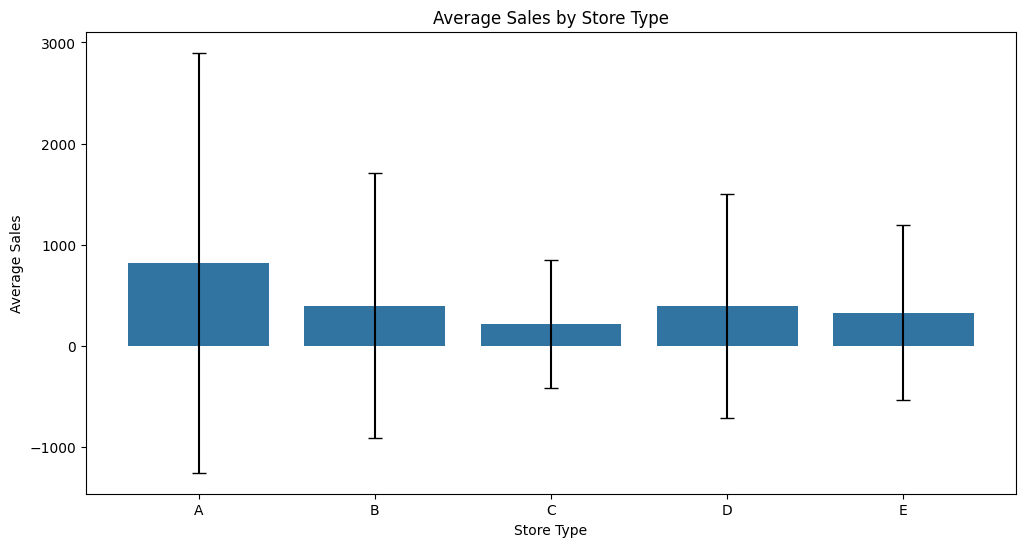

In [64]:
# Calculate the mean and standard deviation of sales for each store type
store_sales_summary = MT3.groupby('store_type')['sales'].agg(['mean', 'std']).reset_index()

# Plotting the average sales with error bars representing the standard deviation
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='store_type', y='mean', data=store_sales_summary, capsize=0.2)

# Adding error bars manually
for index, row in store_sales_summary.iterrows():
    barplot.errorbar(index, row['mean'], yerr=row['std'], fmt='none', c='black', capsize=5)

plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()

**Inference**

1. **Store Type A**: Has the highest average sales and the largest variability, indicating some stores perform very well while others do not.
2. **Other Store Types (B, C, D, E)**: Have lower average sales and smaller variability, suggesting more consistent but generally lower sales performance.
3. **Sales Distribution**: All store types exhibit a wide range of sales values, with negative values indicating potential losses or returns.

#### Answering Analytical Questions
Is the train dataset complete (has all the required dates)?
1. -   Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
2. -  Compare the sales for each month across the years and determine which month of which year had the highest sales.
3. -  Did the earthquake impact sales?
4. -  Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
5. -  Are sales affected by promotions, oil prices and holidays?
6. -  What  analysis can we get from the date and its extractable features?
7. -  Which product family and stores did the promotions affect.
8. -  What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
9. -  Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


**Q1. Is the train dataset complete (has all the required dates)?**

In [22]:
# Find Minimum and maximum Dates for the training dataset
start_date =MT3['date'].min()
end_date =MT3['date'].max()

# Create a complete date range
complete_date_range = pd.date_range(start=start_date, end=end_date)

In [23]:
# Check for missing dates
missing_dates = complete_date_range.difference(df_train['date'])

if missing_dates.empty:
    print("The train dataset has all the required dates.")
else:
    print("The train dataset is missing the following dates:")
    print(missing_dates)

The train dataset is missing the following dates:
DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')


In [30]:
# Check for missing dates
missing_dates = complete_date_range.difference(MT3['date'])

if missing_dates.empty:
    print("The train dataset has all the required dates.")
else:
    print("The train dataset is missing the following dates:")
    print(missing_dates)

The train dataset is missing the following dates:
DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-12',
               '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', length=1509, freq=None)


**Q2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?**

In [24]:
# Filter out days when the store was closed
open_store_df = MT3[MT3['sales'] > 0]

# Group by year and find the date with the lowest and highest sales
lowest_sales_dates = open_store_df.loc[open_store_df.groupby('year')['sales'].idxmin()]
highest_sales_dates = open_store_df.loc[open_store_df.groupby('year')['sales'].idxmax()]

# Print results
print("Dates with the lowest sales for each year:")
print(lowest_sales_dates[['date', 'year', 'sales']])

print("\nDates with the highest sales for each year:")
print(highest_sales_dates[['date', 'year', 'sales']])


Dates with the lowest sales for each year:
             date  year  sales
19370  2013-07-23  2013  0.294
106490 2014-12-05  2014  0.188
152987 2015-08-24  2015  0.300
242285 2016-06-23  2016  0.396
301289 2017-05-01  2017  0.470

Dates with the highest sales for each year:
             date  year     sales
36510  2013-11-12  2013   46271.0
107922 2014-12-08  2014   45361.0
166827 2015-11-11  2015   33274.0
217548 2016-05-02  2016  124717.0
286221 2017-01-02  2017   23966.0


**Q3. Compare the sales for each month across the years and determine which month of which year had the highest sales.**

The highest sales were in 2016-April: $11797704.02


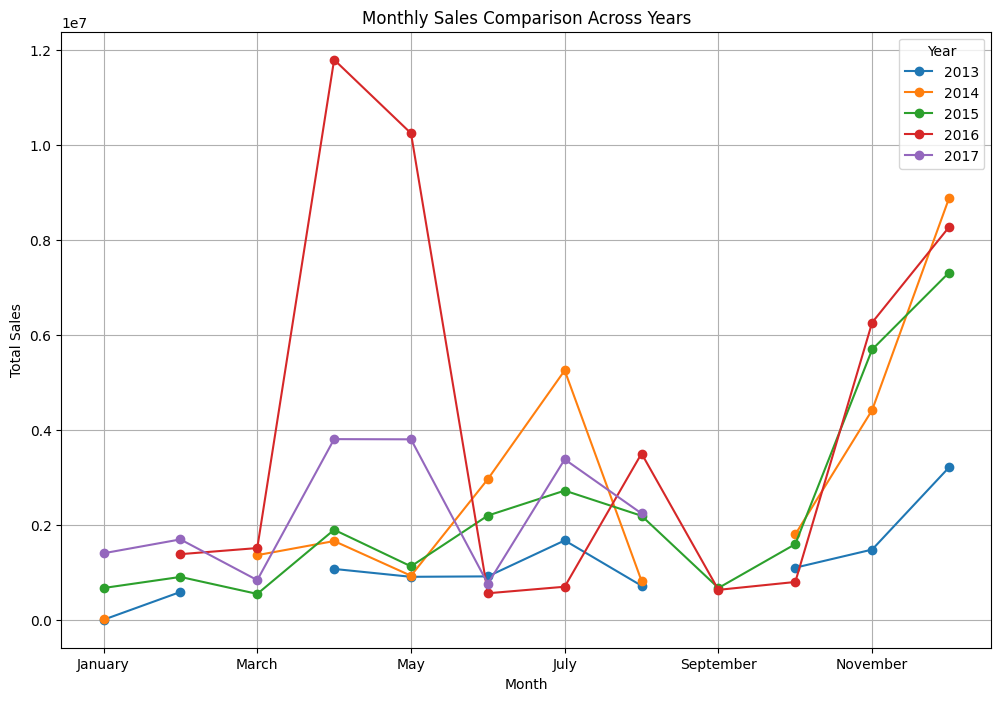

In [26]:
# Group by year and month to get the total sales for each month of each year
monthly_sales = MT3.groupby(['year', 'month_name'])['sales'].sum().reset_index()

# Determine the month and year with the highest sales
highest_sales = monthly_sales.loc[monthly_sales['sales'].idxmax()]

print(f"The highest sales were in {highest_sales['year']}-{highest_sales['month_name']}: ${highest_sales['sales']:.2f}")

# Pivot the data to have years as columns and months as rows for better visualization
monthly_sales_pivot = monthly_sales.pivot(index='month_name', columns='year', values='sales')

# Sort the index to ensure months are in order
monthly_sales_pivot = monthly_sales_pivot.reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot the data

plt.figure(figsize=(12, 8))
monthly_sales_pivot.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Monthly Sales Comparison Across Years')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.grid(True)
plt.show()

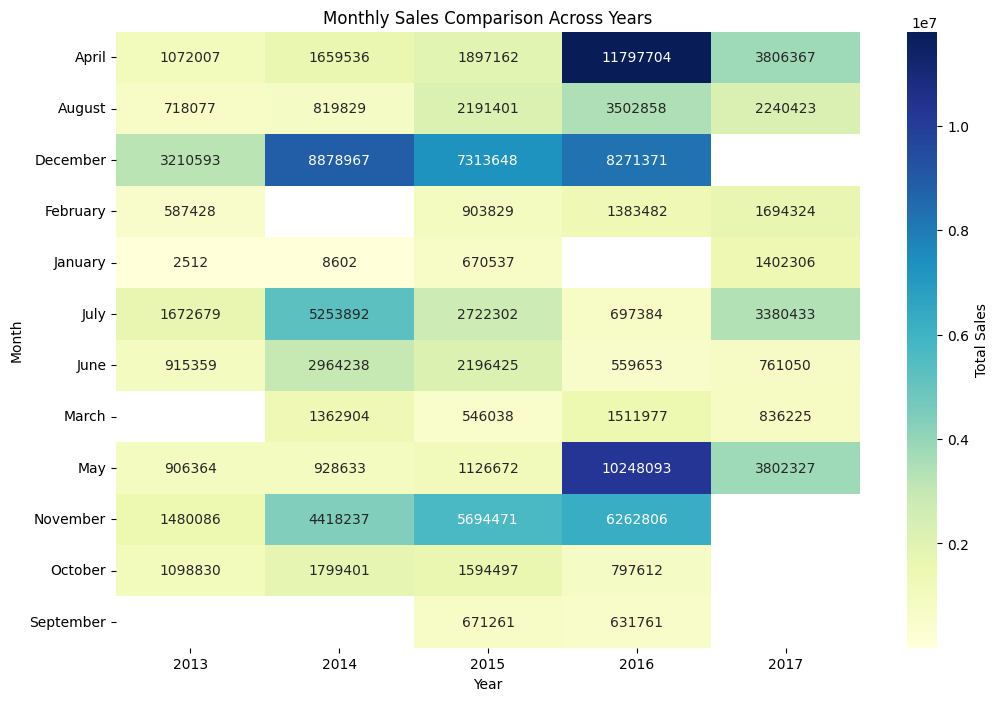

In [69]:
# Plot the data using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_sales_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Total Sales'})
plt.title('Monthly Sales Comparison Across Years')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

**Q4.Are certain stores or groups of stores selling more products? (Cluster, city, state, type)**

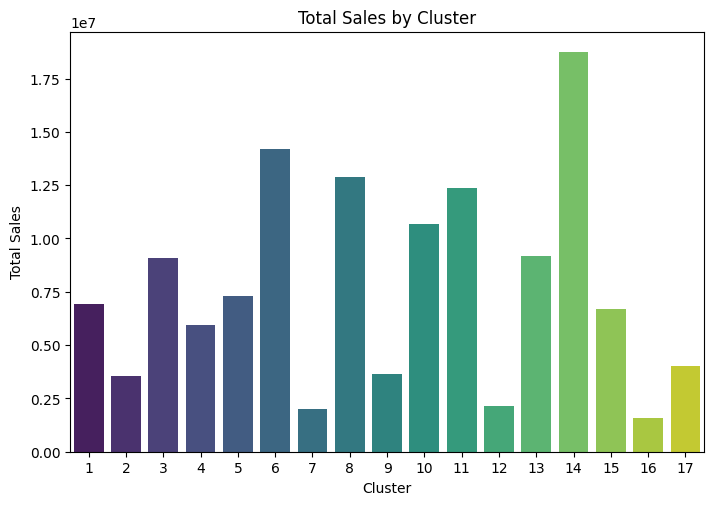

In [27]:
# Group by Cluster, City, State, and Type and calculate total sales
grouped_sales_cluster = MT3.groupby('cluster')['sales'].sum().reset_index()
grouped_sales_city = MT3.groupby('city')['sales'].sum().reset_index()
grouped_sales_state = MT3.groupby('state')['sales'].sum().reset_index()
grouped_sales_type = MT3.groupby('store_type')['sales'].sum().reset_index()

# Set up the figure
plt.figure(figsize=(18, 12))

# Plot sales by cluster
plt.subplot(2, 2, 1)
sns.barplot(data=grouped_sales_cluster, x='cluster', y='sales', palette='viridis')
plt.title('Total Sales by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sales')
plt.show()

**Insights**

1. Cluster 14 has the highest total sales, significantly outperforming other clusters.
2. Clusters 6 and 7 also show high total sales, indicating strong performance.
3. Clusters 3, 4, 5, and 11 have moderate sales, falling in the middle range.
4. Clusters 2, 9, 15, and 17 have relatively low sales compared to others.
5. The chart suggests notable variability in sales performance across different clusters.

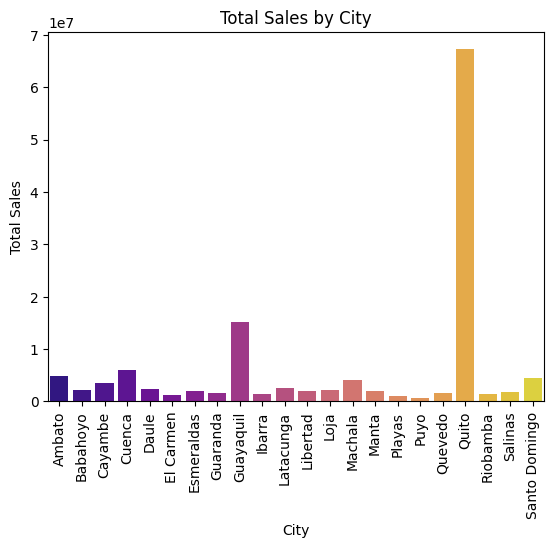

In [71]:
# Plot sales by city
# plt.subplot(2, 2, 2)
sns.barplot(data=grouped_sales_city, x='city', y='sales', palette='plasma')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

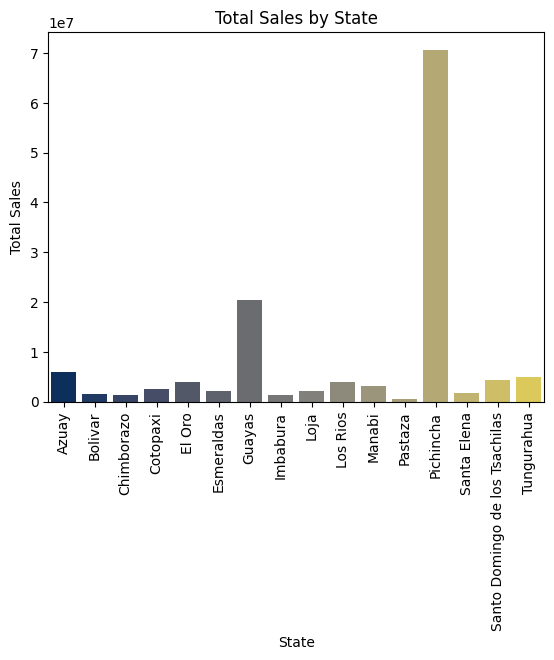

In [72]:
# Plot sales by state

sns.barplot(data=grouped_sales_state, x='state', y='sales', palette='cividis')
plt.title('Total Sales by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.show()

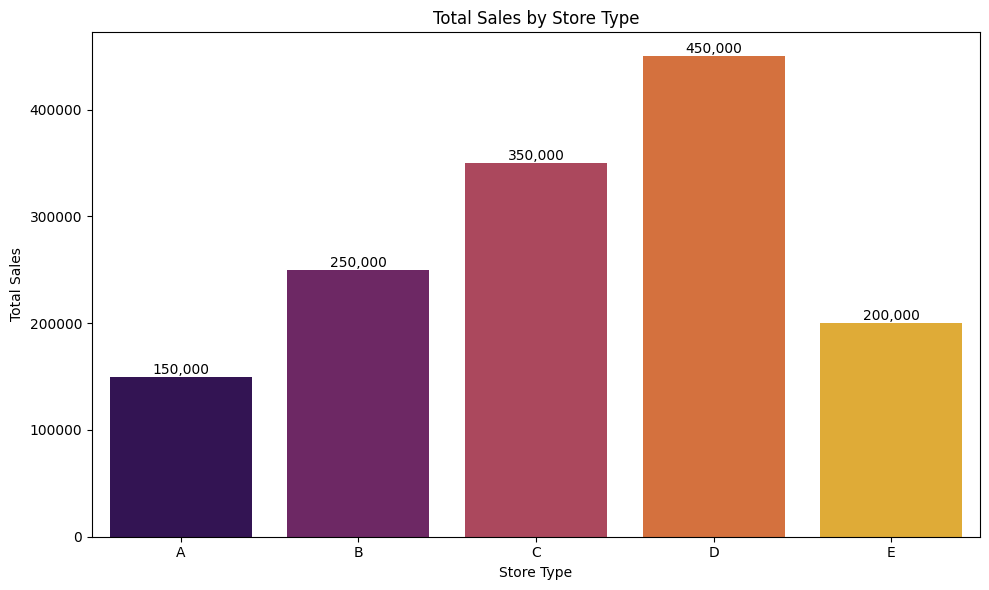

In [73]:

# Example DataFrame for grouped sales by store type
# Replace this with your actual DataFrame
grouped_sales_type = pd.DataFrame({
    'store_type': ['A', 'B', 'C', 'D', 'E'],
    'sales': [150000, 250000, 350000, 450000, 200000]
})

# Plot sales by store type
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_sales_type, x='store_type', y='sales', palette='inferno')

# Add title and labels
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')

# Annotate bars with sales values
for index, row in grouped_sales_type.iterrows():
    plt.text(index, row.sales, f'{row.sales:,}', color='black', ha="center", va="bottom")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### Q4 Did Earthquake Impact sales?

In [32]:
# Drop the 'index' and 'id' columns
new_train_data = MT3.drop(columns=['id'])

#getting two weeks sales before the earthquake
start_date='2016-04-01'
end_date='2016-04-15'
#setting date to datetime
new_train_data['date']=pd.to_datetime(new_train_data['date'])

#getting start and end date using mask function to select rows between dates

mask = (new_train_data['date']>=start_date) & (new_train_data['date']<=end_date)

start_end_df_b4=new_train_data.loc[mask]
start_end_df_b4.head()


,date,oil_price,Holiday_type,store_marketscope,store_location,description,transferred,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,year,month,day,month_name,day_name
192687,2016-04-01,35.360001,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,AUTOMOTIVE,8.0,0,Quito,Pichincha,D,13,1797,2016,4,1,April,Friday
192688,2016-04-01,35.360001,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1797,2016,4,1,April,Friday
192689,2016-04-01,35.360001,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,BEAUTY,2.0,0,Quito,Pichincha,D,13,1797,2016,4,1,April,Friday
192690,2016-04-01,35.360001,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,BEVERAGES,2274.0,8,Quito,Pichincha,D,13,1797,2016,4,1,April,Friday
192691,2016-04-01,35.360001,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1797,2016,4,1,April,Friday


In [33]:
sales_b4= start_end_df_b4['sales'].sum()
print('Total sales before earthquake:', sales_b4)

Total sales before earthquake: 2070909.563282


In [35]:
#getting two weeks sales after the earthquake
start_date='2016-04-17'
end_date='2016-04-30'
#setting date to datetime
new_train_data['date']=pd.to_datetime(new_train_data['date'])

#getting start and end date using mask function to select rows between dates

mask= (new_train_data['date']>=start_date) & (new_train_data['date']<=end_date)

start_end_df_after=new_train_data.loc[mask]
start_end_df_after.head()

,date,oil_price,Holiday_type,store_marketscope,store_location,description,transferred,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,year,month,day,month_name,day_name
197934,2016-04-18,39.740002,Event,National,Ecuador,Terremoto Manabi+2,False,1,AUTOMOTIVE,14.0,0,Quito,Pichincha,D,13,2133,2016,4,18,April,Monday
197935,2016-04-18,39.740002,Event,National,Ecuador,Terremoto Manabi+2,False,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,2133,2016,4,18,April,Monday
197936,2016-04-18,39.740002,Event,National,Ecuador,Terremoto Manabi+2,False,1,BEAUTY,3.0,0,Quito,Pichincha,D,13,2133,2016,4,18,April,Monday
197937,2016-04-18,39.740002,Event,National,Ecuador,Terremoto Manabi+2,False,1,BEVERAGES,4155.0,1,Quito,Pichincha,D,13,2133,2016,4,18,April,Monday
197938,2016-04-18,39.740002,Event,National,Ecuador,Terremoto Manabi+2,False,1,BOOKS,0.0,0,Quito,Pichincha,D,13,2133,2016,4,18,April,Monday


In [36]:
sales_after= start_end_df_after['sales'].sum()
print('Total sales after earthquake:', sales_after)

Total sales after earthquake: 9726794.4533626


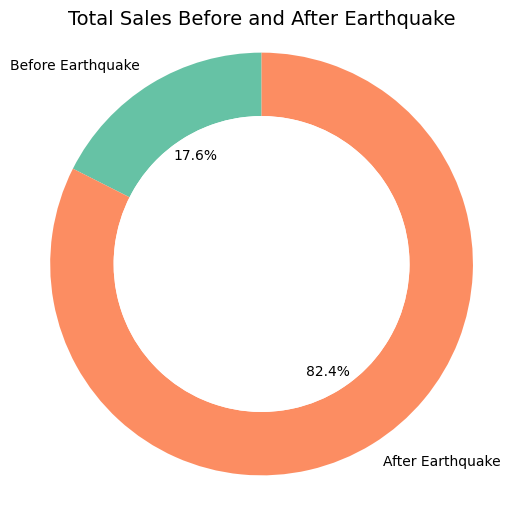

Percentage change in sales after the earthquake: 369.69%


In [37]:
# PLotting the graph

periods = ['Before Earthquake', 'After Earthquake']
sales_totals = [sales_b4, sales_after]

# Calculate the percentage change
percentage_change = ((sales_after - sales_b4) / sales_b4) * 100

# Set a professional color palette
colors = sns.color_palette("Set2")

# Create the donut chart with a smaller figure size
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sales_totals, labels=periods, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.3))

# Add a central circle to create the donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Add title
plt.title('Total Sales Before and After Earthquake', fontsize=14)

# Show the figure
plt.show()

# Print the percentage change
print(f"Percentage change in sales after the earthquake: {percentage_change:.2f}%")


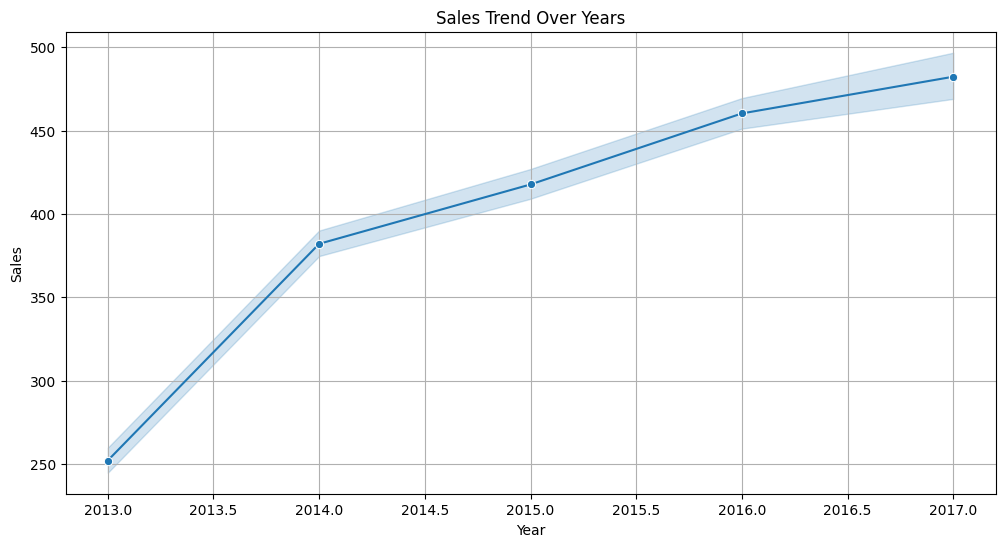

In [38]:
# Analysis of Sales over Years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sales', data=MT3, marker='o')
plt.title('Sales Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

**Insights**

- Upward Trend: There is a clear upward trend in sales from 2013 to 2017. Sales increased consistently every year.

- Growth Rate:
2013 to 2014: The most significant growth occurred between 2013 and 2014, where sales jumped from around 250 to approximately 400.
2014 to 2017: From 2014 to 2017, sales continued to increase but at a more gradual and steady rate.

- Consistency: The shaded area around the line indicates the confidence interval, showing the variability of sales data. The confidence interval is relatively narrow, suggesting that the sales data is consistent and the trend is reliable.

- The consistent increase in sales suggests strong business performance and possibly effective strategies in place.
- Future Expectations: If the trend continues, it is reasonable to expect further sales growth in subsequent years.

**In summary, the trend indicates a positive and consistent increase in sales from 2013 to 2017, with the most substantial growth occurring in the early years of this period.**



**Q5. Are sales affected by promotions, oil prices and holidays?**

Correlation between Sales and Promotions: 0.42
Correlation between Sales and Oil Prices: -0.06
Correlation between Sales and Holidays: nan


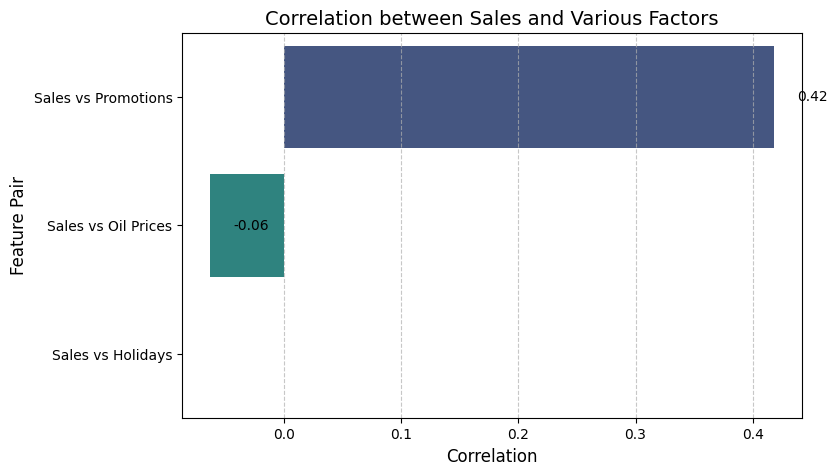

In [40]:

# Calculate correlations
corr_sales_promotions = MT3['sales'].corr(MT3['onpromotion'])
corr_sales_oil = MT3['sales'].corr(MT3['oil_price'])
corr_sales_holidays = MT3['sales'].corr(MT3['Holiday_type'].apply(lambda x: 1 if x == 'holidays' else 0))

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions:.2f}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil:.2f}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays:.2f}")

# Prepare data for plotting
labels = ['Sales vs Promotions', 'Sales vs Oil Prices', 'Sales vs Holidays']
correlations = [corr_sales_promotions, corr_sales_oil, corr_sales_holidays]

# Create a DataFrame to sort the correlations
correlation_df = pd.DataFrame({'Feature Pair': labels, 'Correlation': correlations})
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Plot the correlations
fig, ax = plt.subplots(figsize=(8, 5))  # Reduced figure size
bars = sns.barplot(data=correlation_df, x='Correlation', y='Feature Pair', palette='viridis', orient='h', ax=ax)

# Add value annotations
for p in bars.patches:
    bars.annotate(f'{p.get_width():.2f}', (p.get_width() + 0.02, p.get_y() + p.get_height()/2),
                  ha='left', va='center', fontsize=10, color='black')

# Add titles and labels
plt.title('Correlation between Sales and Various Factors', fontsize=14)
plt.xlabel('Correlation', fontsize=12)
plt.ylabel('Feature Pair', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


**Q6. What  analysis can we get from the date and its extractable features?**

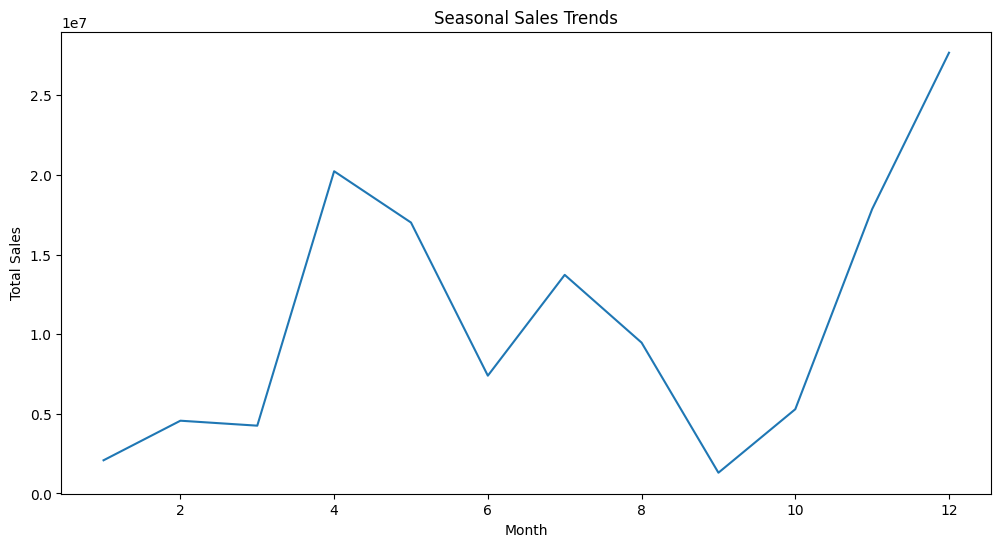

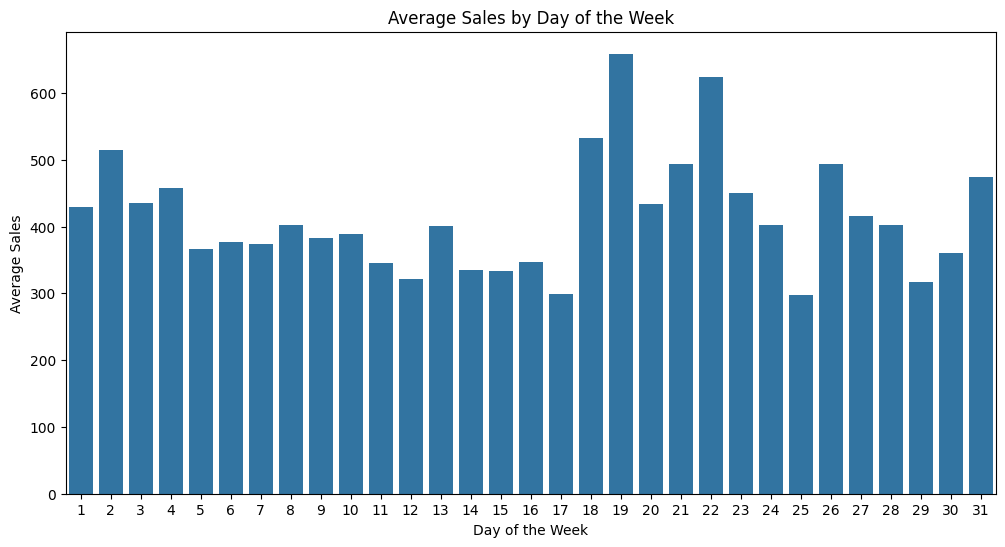

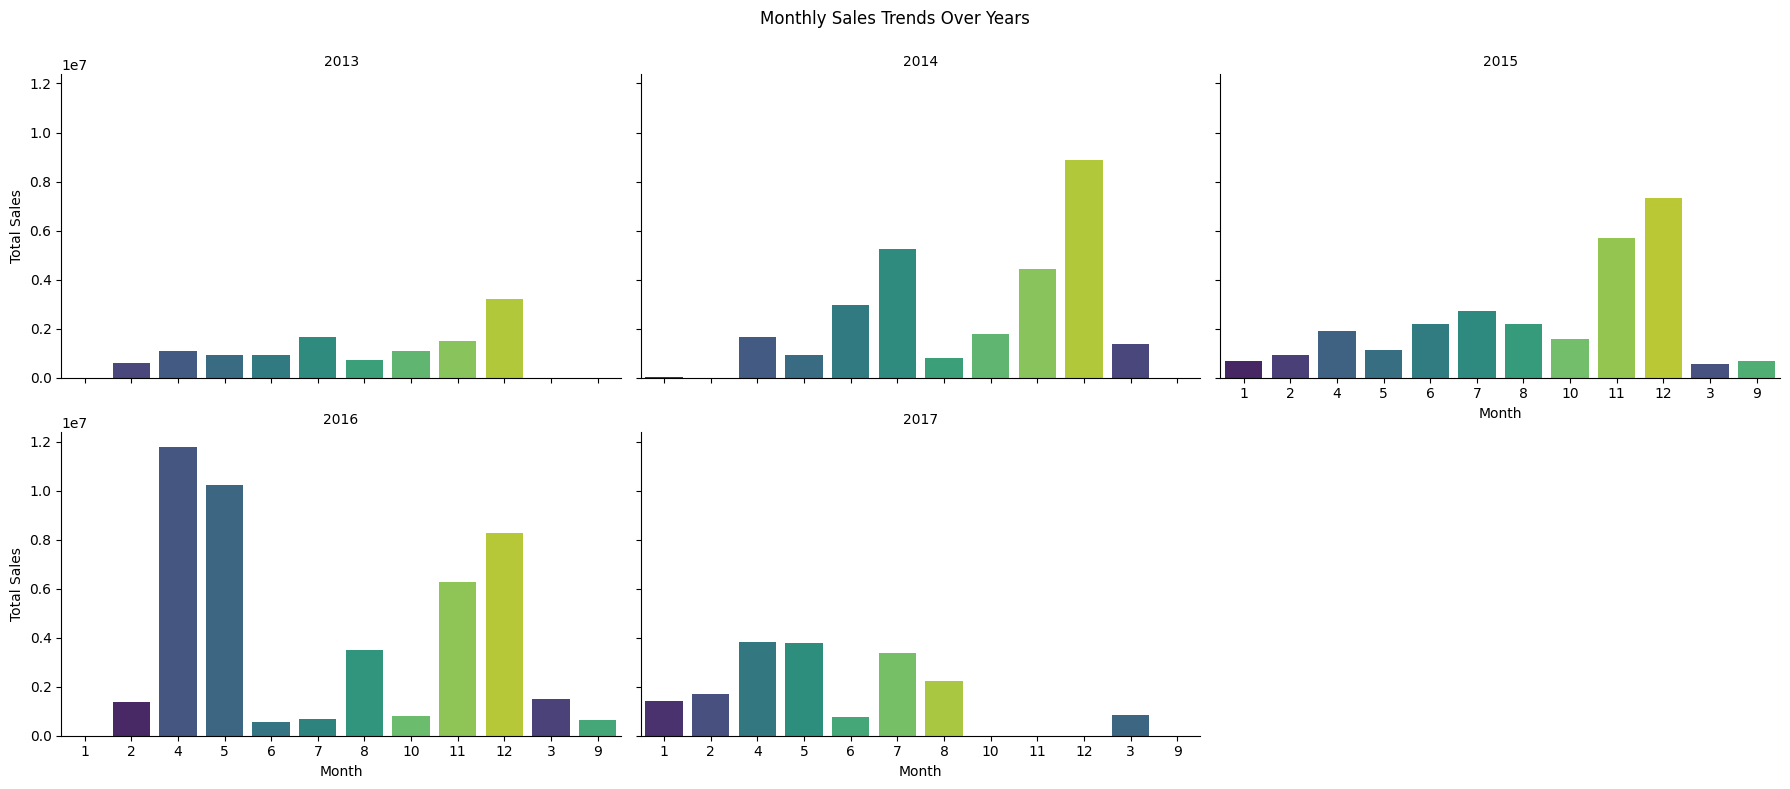

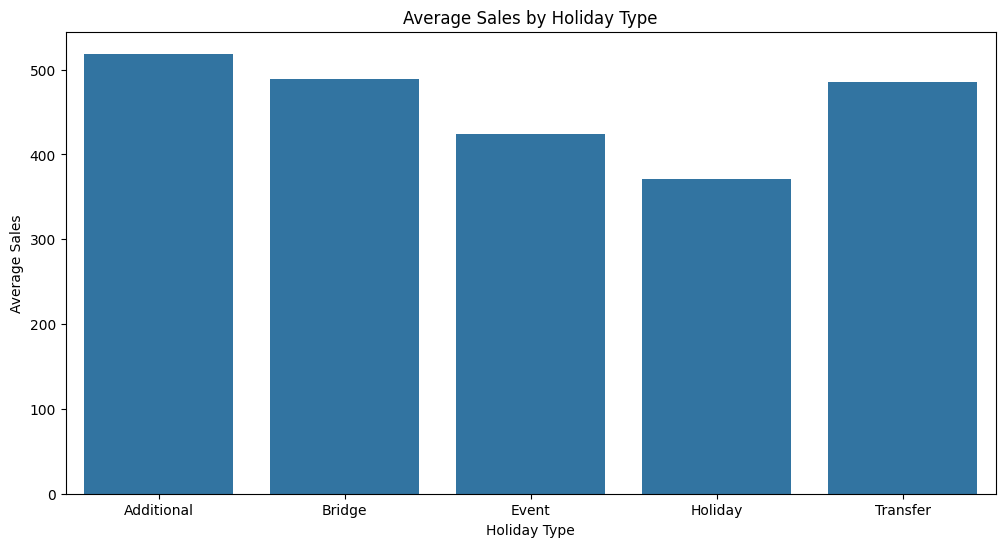

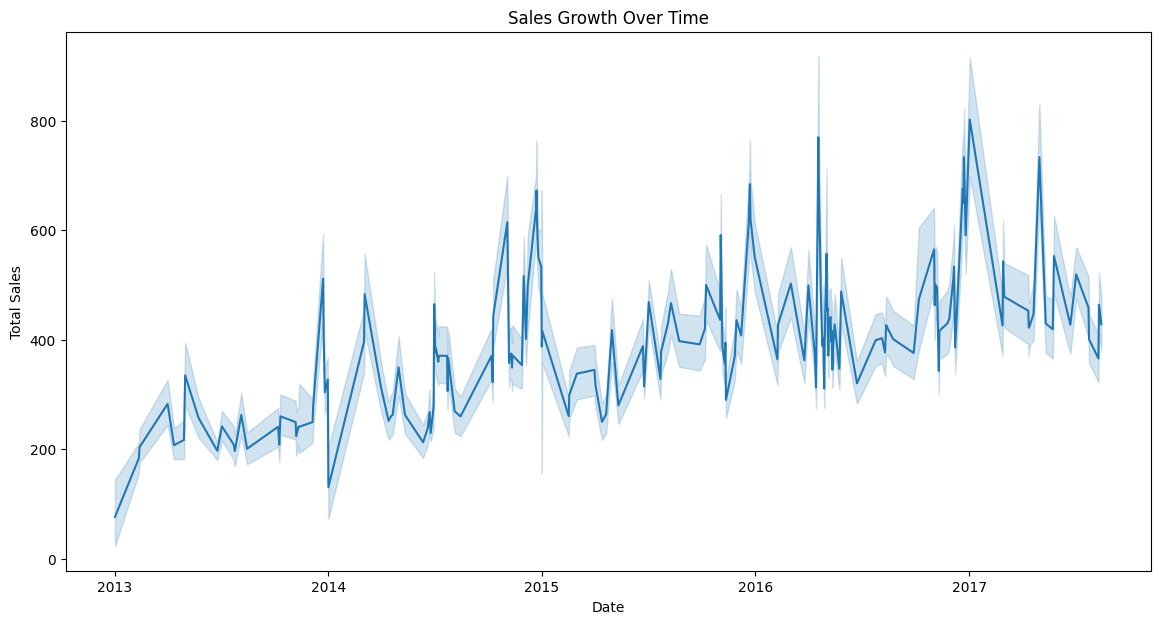

In [43]:
# 7 What analysis can we get from the date and its extractable features
#  Seasonal Trends
# Group by month to observe seasonal trends
seasonal_sales = MT3.groupby('month')['sales'].sum()

# Plotting seasonal sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(x=seasonal_sales.index, y=seasonal_sales.values)
plt.title('Seasonal Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(False)
plt.show()


# Day of the Week Analysis
# Group by day of the week to observe trends
weekday_sales = MT3.groupby('day')['sales'].mean()

# Plotting sales by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.grid(False)
plt.show()

# Group by year and month and sum the sales
monthly_sales = MT3.groupby(['year', 'month'])['sales'].sum().reset_index()

# Plotting the bar plot with subplots for each year
g = sns.FacetGrid(monthly_sales, col="year", col_wrap=3, height=4, aspect=1.5)
g.map(sns.barplot, "month", "sales", palette="viridis")
g.set_axis_labels("Month", "Total Sales")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Monthly Sales Trends Over Years')
plt.show()


# Holiday Impact
# Group by holiday type to observe sales impact
holiday_sales = MT3.groupby('Holiday_type')['sales'].mean()

# Plotting sales by holiday type
plt.figure(figsize=(12, 6))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.title('Average Sales by Holiday Type')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.grid(False)
plt.show()

# Sales Growth Over Time
# Plotting sales over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='sales', data=MT3)
plt.title('Sales Growth Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(False)
plt.show()


Below 

>- 1.Seasonality Analysis: By extracting the month, quarter, or season from the date, we can analyze historical sales patterns and identify recurring seasonal trends. This information can help in predicting future sales during specific periods, such as holidays or seasonal promotions.

>- 2.Day of the Week Analysis: Extracting the day of the week can reveal sales patterns based on weekdays versus weekends. This analysis can help identify differences in customer behavior, such as higher sales on weekends or specific days when certain products or promotions perform better.

>- 3.Holiday and Event Analysis: Identifying holidays, festivals, or major events from the date can help predict sales spikes or lulls. By analyzing historical sales data during these periods, you can forecast future sales based on the impact of specific events and plan promotional strategies accordingly.

>- 4.Trend Analysis: By analyzing the sequential order of dates and sales data, you can identify overall trends and patterns. Techniques like moving averages or regression analysis can be applied to extract underlying trends and forecast future sales based on those trends.

**Q7. Which product family and stores did the promotions affect.**

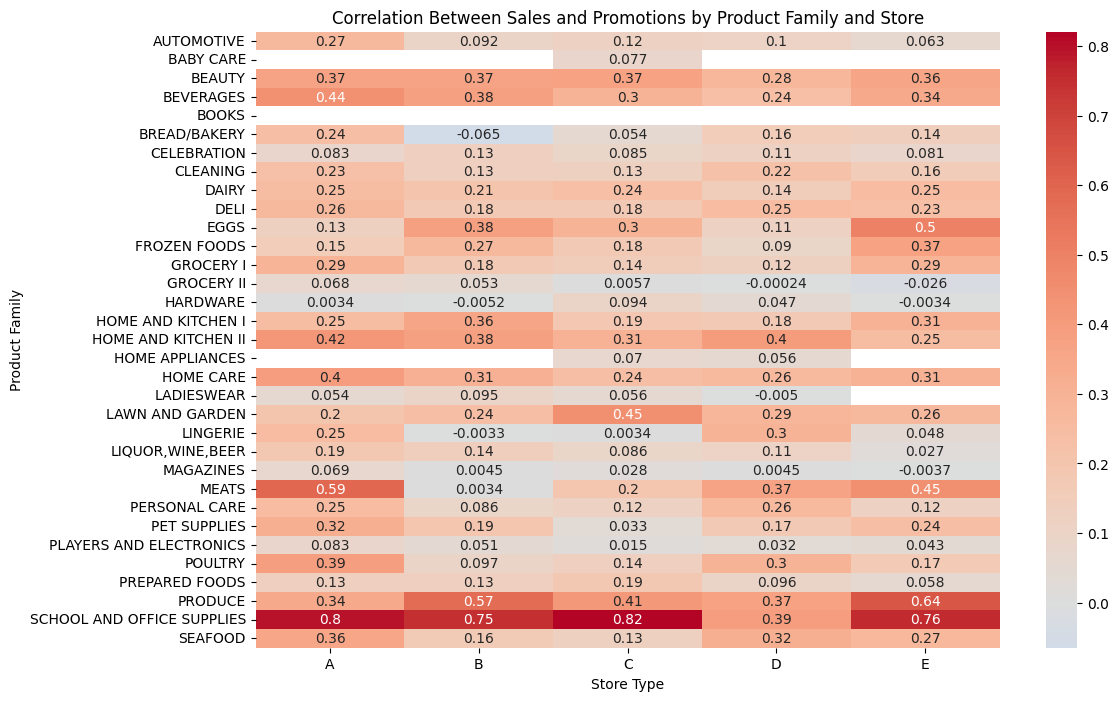

In [164]:

# Assuming MT3 is your DataFrame and it has columns named 'family', 'store_type', 'sales', and 'onpromotion'

# Create a pivot table to calculate correlation between sales and promotions for each product family and store
correlation_data = MT3.groupby(['family', 'store_type']).apply(
    lambda x: x['sales'].corr(x['onpromotion'])
).unstack()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Sales and Promotions by Product Family and Store')
plt.xlabel('Store Type')
plt.ylabel('Product Family')
plt.show()


**Infrence**

-**School and Office Supplies:** Exhibits very strong positive correlations in store types A, B, C, and E, indicating promotions significantly boost sales in these categories
- **Meats:** Shows notable positive correlations in store types A, D, and E, suggesting promotions effectively increase sales in these stores.

- **Produce:** Strong positive correlations in store types B, C, and E, highlighting the impact of promotions on sales.

- **Beverages and Beauty, Home and Kitchen II and Home Care:** Display moderate positive correlations across most store types, indicating a reasonable impact of promotions on sales.
 
 - **Magazines,Lingerine, Books and Hardware :** Exhibits weak or negligible correlations, indicating a minimal impact of promotions on sales

 **General Observations:**

- *Promotions* tend to have a more pronounced impact on product families with frequent or seasonal demand (e.g., School and Office Supplies, Meats).
- *Store type E* shows significant positive correlations in multiple categories, indicating that promotions are particularly effective in these stores.
- *Store types A and B* also frequently show strong positive correlations, suggesting these store types benefit more from promotional activities across various product families.


**Q8. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)**

Answer
- RMSE (Root Mean Squared Error): Measures the square root of the average of the squared differences between predicted and actual values. It penalizes larger errors more than smaller ones because the errors are squared.

- MSE (Mean Squared Error): Measures the average of the squared differences between predicted and actual values. Like RMSE, it penalizes larger errors more heavily.

- MAE (Mean Absolute Error): Measures the average of the absolute differences between predicted and actual values. It is less sensitive to outliers compared to RMSE and MSE.

Why MAE Is Greater Than All
- MAE provides a linear penalty for errors, while MSE and RMSE square the errors, which makes them more sensitive to larger errors.
- If the errors are small and relatively consistent, MAE can be greater than RMSE or MSE because the latter metrics are more affected by large deviations.
- MAE does not exaggerate larger errors, so if there are a few large errors, MSE and RMSE might be smaller due to their penalization, whereas MAE remains steady.

- MAE gives a straightforward measure of average error sizewhile MSE and RMSE provide a more severe penalty for larger errors.


**Q10.  Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.** 

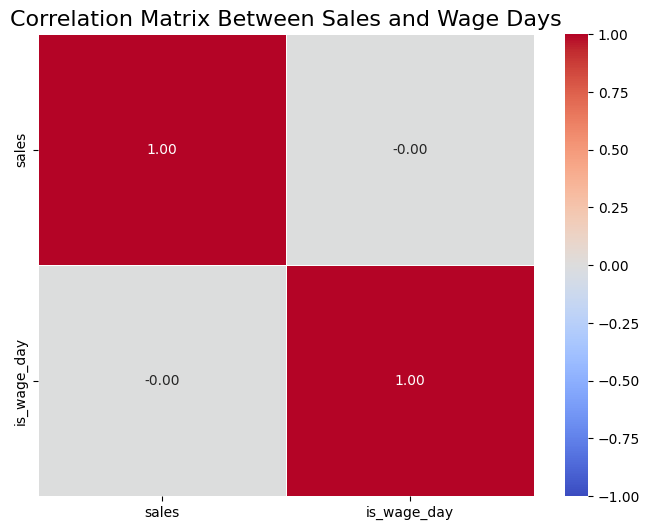

Correlation between Sales and Wage Days: -0.00


In [44]:
# Create a new column to identify if the date is the 15th or the last day of the month
MT3['day'] = MT3['date'].dt.day
MT3['last_day_of_month'] = MT3['date'] + pd.offsets.MonthEnd(0)
MT3['is_wage_day'] = MT3.apply(lambda row: 1 if row['day'] == 15 or row['date'] == row['last_day_of_month'] else 0, axis=1)

# Calculate correlation matrix
correlation_matrix = MT3[['sales', 'is_wage_day']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix Between Sales and Wage Days', fontsize=16)
plt.show()

# Print the correlation value
correlation = correlation_matrix.loc['sales', 'is_wage_day']
print(f"Correlation between Sales and Wage Days: {correlation:.2f}")


#### **Hypothesis Test**

ADF Statistic: -34.96709386762316
p-value: 0.0


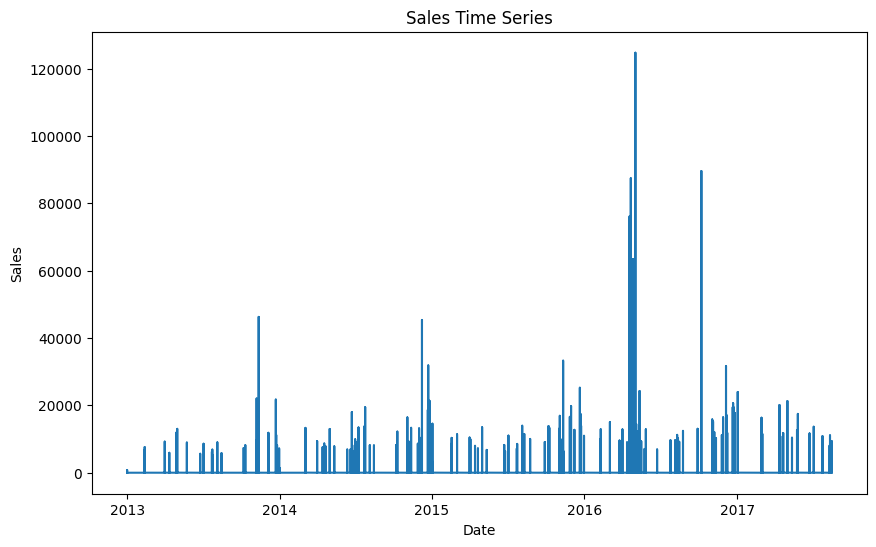

Reject the null hypothesis (H0). The time series is stationary.


In [165]:
# Using the Augmented Dickey-Fuller (ADF) test to determine Stationarity
from statsmodels.tsa.stattools import adfuller

# Set the 'date' as the index
MT3.set_index('date', inplace=True)

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(MT3['sales'])

# Extract the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(MT3['sales'])
plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis (H0). The time series is stationary.")
else:
    print("Fail to reject the null hypothesis (H0). The time series is not stationary.")


<Figure size 1500x800 with 0 Axes>

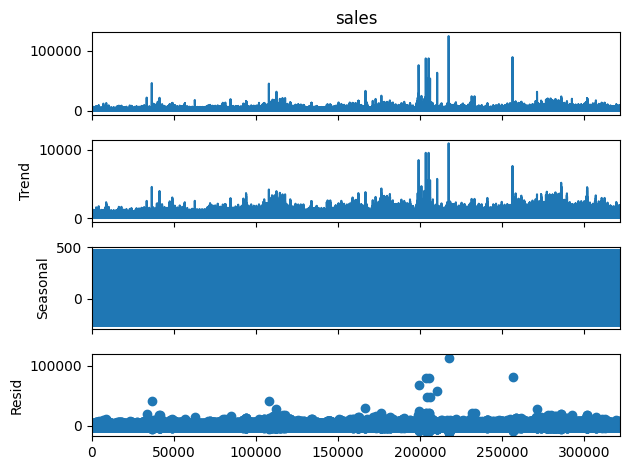

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(MT3['sales'], model='additive', period=12)

# Plot the decomposed components
plt.figure(figsize=(15,8))
result.plot()
plt.show()


**Insights/Inference**
- Original Series (Sales):
The top plot represents the raw sales data over time.
Noticeable peaks can be seen, indicating periods of high sales activity, which are likely due to promotions, holidays, or other significant events.
- Trend Component:

The second plot shows the underlying trend in the sales data.
The trend line captures the long-term movement in sales, reflecting overall increases or decreases.
There are visible upward and downward trends, showing periods where sales were consistently rising or falling.
- Seasonal Component:

The third plot depicts the seasonal component, representing recurring patterns or cycles in the sales data.
The regular oscillations indicate a consistent seasonal effect, suggesting that sales fluctuate in a predictable manner at certain intervals (e.g., monthly or yearly).
The seasonal peaks and troughs occur at regular intervals, highlighting the presence of strong seasonality in the sales data.
- Residual (Noise) Component:

The bottom plot shows the residuals, which are the remaining variations in the data after removing the trend and seasonal components.
The residuals represent the random noise or irregularities in the sales data that cannot be explained by the trend or seasonality.
Larger residuals may indicate significant deviations from the expected pattern, which could be due to unusual events or outliers.

Creating Lag Features

In [47]:
# Assuming you have a DataFrame 'data' with a 'Close column
# Example data
data = pd.DataFrame({
'date': pd.date_range(start='2013-01-01', periods=5, freq='D'),
'sales': [150000, 250000, 350000, 450000, 200000]
})

# Add lagged features
data['lag_1'] = data['sales'].shift(1)
data['lag_2'] = data['sales'].shift(2)
data['lag_3'] = data['sales'].shift(3)
data['lag_4'] = data['sales'].shift(4)
data['lag_5'] = data['sales'].shift(5)
print(data)
 

        date   sales     lag_1     lag_2     lag_3     lag_4  lag_5
0 2013-01-01  150000       NaN       NaN       NaN       NaN    NaN
1 2013-01-02  250000  150000.0       NaN       NaN       NaN    NaN
2 2013-01-03  350000  250000.0  150000.0       NaN       NaN    NaN
3 2013-01-04  450000  350000.0  250000.0  150000.0       NaN    NaN
4 2013-01-05  200000  450000.0  350000.0  250000.0  150000.0    NaN


### Data Preparation and Modelling


In [45]:
# Create a copy of the dataframe 
df_train_copy1 = MT3.copy()

AutoRegressionModel(AR)

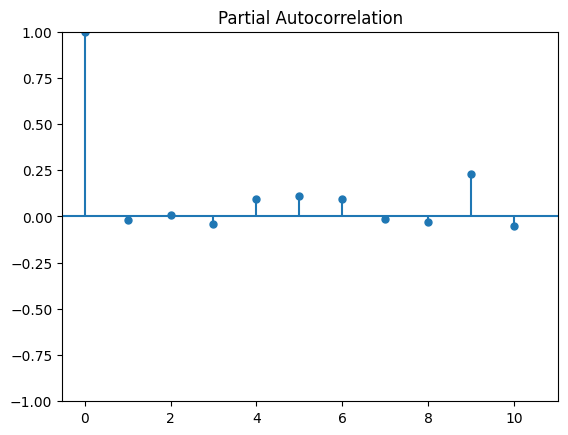

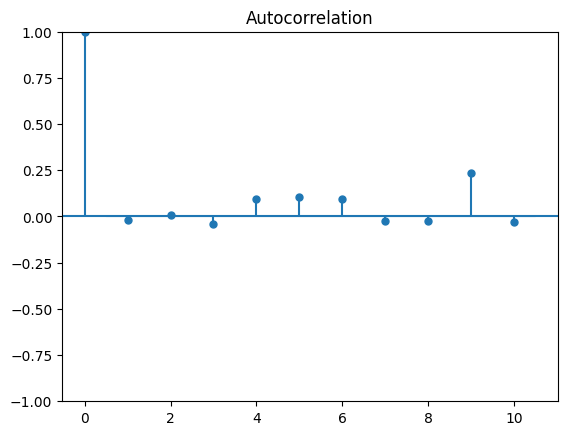

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(MT3['sales'], lags=10)
acf = plot_acf(MT3['sales'], lags=10)

In [35]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(MT3['sales'],lags = 5).fit()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:               322047
Model:                     AutoReg(5)   Log Likelihood            -2748924.432
Method:               Conditional MLE   S.D. of innovations           1232.723
Date:                Wed, 24 Jul 2024   AIC                        5497862.864
Time:                        13:22:37   BIC                        5497937.641
Sample:                             5   HQIC                       5497884.427
                               322047                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        344.6124      2.696    127.843      0.000     339.329     349.896
sales.L1      -0.0234      0.002    -13.360      0.000      -0.027      -0.020
sales.L2       0.0094      0.002      5.388      0.000       0.006       0.013
sales.L3      -0.0387      0.002    -22.196      0.000      -0.042      -0.035
sales.L4       0.0937      0.002     53.712      0.000       0.090       0.097
sales.L5       0.1110      0.002     63.396      0.000       0.108       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4519           -0.0000j            1.4519           -0.0000
AR.2            0.3439           -1.4243j            1.4653           -0.2123
AR.3            0.3439           +1.4243j            1.4653            0.2123
AR.4           -1.4917           -0.8151j            1.6999           -0.4204
AR.5           -1.4917           +0.8151j            1.6999            0.4204
-----------------------------------------------------------------------------
"""

**Insights**

**Analysis of p-values**

**P-values:** All p-values for the coefficients of the lagged sales terms (sales.L1 to sales.L5) are 0.000, indicating that these coefficients are statistically significant at conventional levels (e.g., 0.05, 0.01).
-  This suggests that each lagged term in the model has a significant effect on the current value of sales.

**Interpreting Coefficients:** The sign and magnitude of each coefficient provide insights into the nature of the relationships between the past and present values of sales. For instance, a positive coefficient for sales.
L4 and salesL5 suggests that past values at these lags positively influence current sales, while a negative coefficient for sales.L1 and sales.L3 indicates an inverse relationship.

#### Dropping Unneccessary Columns in The Merged and Test Datasets as it is not needed for our analysis

In [48]:
columns_to_drop = ['date','id', 'store_marketscope', 'store_location', 'description', 'store_type', 'transferred', 'state', 'month_name','day_name', 'last_day_of_month', 'is_wage_day']
MT3_copy = MT3.drop(columns=columns_to_drop)

MT3_copy.head()

,oil_price,Holiday_type,store_nbr,family,sales,onpromotion,city,cluster,transactions,year,month,day
0,NaN,Holiday,25,AUTOMOTIVE,0.0,0,Salinas,1,770,2013,1,1
1,NaN,Holiday,25,BABY CARE,0.0,0,Salinas,1,770,2013,1,1
2,NaN,Holiday,25,BEAUTY,2.0,0,Salinas,1,770,2013,1,1
3,NaN,Holiday,25,BEVERAGES,810.0,0,Salinas,1,770,2013,1,1
4,NaN,Holiday,25,BOOKS,0.0,0,Salinas,1,770,2013,1,1


In [80]:
# Save the DataFrame to a CSV file
MT3_copy.to_csv('MT3_copy.csv', index=False)


#### Perform backfill on oil_price

In [49]:
# Perform backfill for missing values in oil_price
MT3_copy['oil_price'] = MT3_copy['oil_price'].bfill()

# Verify that there are no missing values left in the oil_price column
print(MT3_copy['oil_price'].isnull().sum())

0


#### Product Categorization Based on Families

In [50]:
unique_families = MT3_copy['family'].unique()
unique_families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [58]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
MT3_copy['family'] = np.where(MT3_copy['family'].isin(food_families), 'FOODS', MT3_copy['family'])
MT3_copy['family'] = np.where(MT3_copy['family'].isin(home_families), 'HOME', MT3_copy['family'])
MT3_copy['family'] = np.where(MT3_copy['family'].isin(clothing_families), 'CLOTHING', MT3_copy['family'])
MT3_copy['family'] = np.where(MT3_copy['family'].isin(grocery_families), 'GROCERY', MT3_copy['family'])
MT3_copy['family'] = np.where(MT3_copy['family'].isin(stationery_families), 'STATIONERY', MT3_copy['family'])
MT3_copy['family'] = np.where(MT3_copy['family'].isin(cleaning_families), 'CLEANING', MT3_copy['family'])
MT3_copy['family'] = np.where(MT3_copy['family'].isin(hardware_families), 'HARDWARE', MT3_copy['family'])

# Print the updated DataFrame
MT3_copy.head()

,oil_price,Holiday_type,store_nbr,family,sales,onpromotion,city,cluster,transactions,year,month,day
0,1.342755,Holiday,25,AUTOMOTIVE,-0.325920,0,Salinas,1,-0.917916,2013,1,1
1,1.342755,Holiday,25,CLEANING,-0.325920,0,Salinas,1,-0.917916,2013,1,1
2,1.342755,Holiday,25,BEAUTY,-0.324316,0,Salinas,1,-0.917916,2013,1,1
3,1.342755,Holiday,25,FOODS,0.323701,0,Salinas,1,-0.917916,2013,1,1
4,1.342755,Holiday,25,STATIONERY,-0.325920,0,Salinas,1,-0.917916,2013,1,1


### Feature Scaling

In [55]:
from sklearn.preprocessing import StandardScaler

# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'oil_price']

# fit and transform the numerical columns
MT3_copy[num_cols] = scaler.fit_transform(MT3_copy[num_cols])

# Display the updated dataframe
MT3_copy.head()

,oil_price,Holiday_type,store_nbr,family,sales,onpromotion,city,cluster,transactions,year,month,day
0,1.342755,Holiday,25,AUTOMOTIVE,-0.325920,0,Salinas,1,-0.917916,2013,1,1
1,1.342755,Holiday,25,CLEANING,-0.325920,0,Salinas,1,-0.917916,2013,1,1
2,1.342755,Holiday,25,BEAUTY,-0.324316,0,Salinas,1,-0.917916,2013,1,1
3,1.342755,Holiday,25,FOODS,0.323701,0,Salinas,1,-0.917916,2013,1,1
4,1.342755,Holiday,25,STATIONERY,-0.325920,0,Salinas,1,-0.917916,2013,1,1


### Encoding The Categorical Variables

In [56]:
from sklearn.preprocessing import OneHotEncoder

# Define the categorical columns to encode
categorical_columns = ["family", "city", "Holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(MT3_copy[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([MT3_copy, merged_df_encoded], axis=1)

# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_df_encoded.head()

,oil_price,store_nbr,sales,onpromotion,cluster,transactions,year,month,day,family_AUTOMOTIVE,family_BEAUTY,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_GROCERY,family_HARDWARE,family_HOME,family_LADIESWEAR,family_LAWN AND GARDEN,"family_LIQUOR,WINE,BEER",family_PET SUPPLIES,family_STATIONERY,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,Holiday_type_Additional,Holiday_type_Bridge,Holiday_type_Event,Holiday_type_Holiday,Holiday_type_Transfer
0,1.342755,25,-0.325920,0,1,-0.917916,2013,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.342755,25,-0.325920,0,1,-0.917916,2013,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.342755,25,-0.324316,0,1,-0.917916,2013,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.342755,25,0.323701,0,1,-0.917916,2013,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.342755,25,-0.325920,0,1,-0.917916,2013,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Test Dataset

In [59]:
# Test Data
df_submission = pd.read_csv(r'C:\Users\Josephine\Desktop\Career Accelerator\Time-Series-Regression-Analysis\Datasets\sample_submission.csv')
df_test= pd.read_csv(r'C:\Users\Josephine\Desktop\Career Accelerator\Time-Series-Regression-Analysis\Datasets\test.csv')

In [60]:
df_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [61]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [71]:
# Merge the two Datasets
# Merge the DataFrames based on index
test_df = pd.merge(df_test, df_submission)

test_df

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.0
1,3000889,2017-08-16,1,BABY CARE,0,0.0
2,3000890,2017-08-16,1,BEAUTY,2,0.0
3,3000891,2017-08-16,1,BEVERAGES,20,0.0
4,3000892,2017-08-16,1,BOOKS,0,0.0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,0.0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,0.0
28509,3029397,2017-08-31,9,PRODUCE,1,0.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,0.0


In [68]:
# Extracting Date Components
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df.head()

,id,date,store_nbr,family,onpromotion,sales,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.0,2017,8,16
1,3000889,2017-08-16,1,BABY CARE,0,0.0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,0.0,2017,8,16
3,3000891,2017-08-16,1,BEVERAGES,20,0.0,2017,8,16
4,3000892,2017-08-16,1,BOOKS,0,0.0,2017,8,16


In [69]:
# Product Categorization Based on Families
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI', 'PRODUCE', 'DAIRY', 'POULTRY', 'EGGS', 'SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE', 'PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS', 'HARDWARE']

test_df['family'] = np.where(test_df['family'].isin(food_families), 'FOODS', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(home_families), 'HOME', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(clothing_families), 'CLOTHING', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(grocery_families), 'GROCERY', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(stationery_families), 'STATIONERY', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(cleaning_families), 'CLEANING', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(hardware_families), 'HARDWARE', test_df['family'])

# Print the updated DataFrame
test_df.head()

,id,date,store_nbr,family,onpromotion,sales,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.0,2017,8,16
1,3000889,2017-08-16,1,CLEANING,0,0.0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,0.0,2017,8,16
3,3000891,2017-08-16,1,FOODS,20,0.0,2017,8,16
4,3000892,2017-08-16,1,STATIONERY,0,0.0,2017,8,16


In [70]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ["family"]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'test_df' data for the specified categorical columns
one_hot_encoded_data = encoder.fit_transform(test_df[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
test_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
test_df_encoded = pd.concat([test_df, test_df_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
test_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
test_df_encoded.head()

,id,date,store_nbr,onpromotion,sales,year,month,day,family_AUTOMOTIVE,family_BEAUTY,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_GROCERY,family_HARDWARE,family_HOME,family_LADIESWEAR,family_LAWN AND GARDEN,"family_LIQUOR,WINE,BEER",family_PET SUPPLIES,family_STATIONERY
0,3000888,2017-08-16,1,0,0.0,2017,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3000889,2017-08-16,1,0,0.0,2017,8,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3000890,2017-08-16,1,2,0.0,2017,8,16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3000891,2017-08-16,1,20,0.0,2017,8,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3000892,2017-08-16,1,0,0.0,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [72]:
train_set = merged_df_encoded.loc[merged_df_encoded['year'].isin([2013, 2014, 2015, 2016])]
test_set = merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [73]:
test_set.shape

(37158, 50)

In [75]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

,Model,RMSLE,RMSE,MSE,MAE


In [77]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = test_set.drop('sales', axis=1)  
y_eval = test_set['sales']

### Model 2: Linear Regression Model

In [78]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
lr_mse = mean_squared_error(y_eval, lr_predictions)
lr_mae = mean_absolute_error(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)

# Print the results_lr dataframe
results_lr

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,0.27,0.84,0.71,0.37


### Model 3: Random Forest Model

In [79]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Random Forest,0.23,0.74,0.55,0.26


Model 3: GradientBoosting Model

In [ ]:
# Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_eval)

# Calculate metrics
gb_mse = mean_squared_error(y_eval, gb_predictions)
gb_mae = mean_absolute_error(y_eval, gb_predictions)

# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gb_predictions_abs = abs(gb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gb_predictions_abs))

# Create a DataFrame to store results for Gradient Boosting
results_gb = pd.DataFrame({'Model': ['Gradient Boosting'],
                            'RMSLE': [gb_rmsle],
                            'RMSE': [np.sqrt(gb_mse)],
                            'MSE': [gb_mse],
                            'MAE': [gb_mae]}).round(2)

# Print the results_gb dataframe
results_gb

### ARIMA Model

In [ ]:
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
results_arima


### 5. SARIMA Model

In [ ]:

# Set the order and seasonal order parameters
# Seasonal autoregress/ive order
P = 0  
# Seasonal differencing order
D = 0  
# Seasonal moving average order
Q = 0  
# Number of time steps in each season (chosen based on the number of months each year)
s = 12  

# Create an instance of the SARIMA model
sarima_model = SARIMAX(endog=y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
sarima_fit = sarima_model.fit()

# Make predictions on the evaluation data
sarima_predictions = sarima_fit.forecast(steps=len(y_eval), exog=X_eval)

# Calculate metrics
sarima_mse = mean_squared_error(y_eval, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(y_eval, sarima_predictions)
sarima_rmsle = np.sqrt(mean_squared_error(np.log1p(y_eval), np.log1p(sarima_predictions)))

# Create a DataFrame to store results for SARIMA
results_sarima = pd.DataFrame({'Model': ['SARIMA'],
                                'RMSLE': [sarima_rmsle],
                                'RMSE': [sarima_rmse],
                                'MSE': [sarima_mse],
                                'MAE': [sarima_mae]}).round(2)

# Print the results_sarima dataframe
results_sarima

In [ ]:
AR_pred=model.predict(start= len(MT3['sales']),
                      end = len(MT3['sales']+(test_data))

**Key Insights or What to do** 

- We would join the 3 tables from the sql database to the train dataset which is data 4 and 5.Test data1 and 2 would not be used during the training session
- from there we work with it
- There are no duplicates and null values except for table1 with 43 null values
- amazingly the data has a lot of null values after joining them together.